# Анализ спроса на самокаты

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
# Использование стиля
plt.style.use('ggplot')

## Предобработка данных о погоде

In [79]:
# Чтение данных и удаление первой строки с единицами измерения
df = pd.read_csv('weather.csv', na_values="", parse_dates=['Datetime']).drop(index=0, axis=1)

# Названия колонок к PEP8
df.columns = df.columns.str.replace(' ', '_').str.lower()

# Приведение колонок к float, кроме колонки с датами
for col in df.columns[1:]:
    df[col] = df[col].astype(float)

### Проверка на дубликаты

In [80]:
df.duplicated().sum(), df['datetime'].duplicated().sum()

(np.int64(0), np.int64(0))

### Работа с пропусками

In [81]:
df.isna().sum() # Проверка наличия пропусков

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

Так как мы работаем с временными рядами, в заполнении пропусков может помочь **интерполяция**, которая отталкивается от значений соседних точек.

#### ДО

In [82]:
df.iloc[1004:1014]

datetime  temperature  precipitation_total  wind_gust  \
1005 2023-05-12 20:00:00    13.690246                  0.0  14.400000   
1006 2023-05-12 21:00:00          NaN                  0.0  12.959999   
1007 2023-05-12 22:00:00          NaN                  0.0  14.040000   
1008 2023-05-12 23:00:00          NaN                  0.0  14.040000   
1009 2023-05-13 00:00:00          NaN                  0.0  13.679999   
1010 2023-05-13 01:00:00          NaN                  0.0  12.959999   
1011 2023-05-13 02:00:00          NaN                  0.0  12.599999   
1012 2023-05-13 03:00:00          NaN                  0.0  11.159999   
1013 2023-05-13 04:00:00          NaN                  0.0  10.799999   
1014 2023-05-13 05:00:00    11.870245                  0.0  11.520000   

      wind_speed  cloud_cover_total  sunshine_duration  
1005    5.506941               26.0           0.000000  
1006    6.569383               20.0           0.000000  
1007    7.244860               38.0           0.000000  
1008    6.618519               38.0           0.000000  
1009    7.729527               25.0           0.000000  
1010    7.172949               23.7           0.000000  
1011    8.557102               23.1           0.000000  
1012    6.725354               59.0           0.000000  
1013    6.638072               77.0           1.440741  
1014    6.877790               91.0           4.848486

#### ПОСЛЕ

In [83]:
for col in df.columns[1:]:
    df[col] = df[col].interpolate()
    
df.iloc[1004:1014]

datetime  temperature  precipitation_total  wind_gust  \
1005 2023-05-12 20:00:00    13.690246                  0.0  14.400000   
1006 2023-05-12 21:00:00    13.488024                  0.0  12.959999   
1007 2023-05-12 22:00:00    13.285801                  0.0  14.040000   
1008 2023-05-12 23:00:00    13.083579                  0.0  14.040000   
1009 2023-05-13 00:00:00    12.881357                  0.0  13.679999   
1010 2023-05-13 01:00:00    12.679134                  0.0  12.959999   
1011 2023-05-13 02:00:00    12.476912                  0.0  12.599999   
1012 2023-05-13 03:00:00    12.274690                  0.0  11.159999   
1013 2023-05-13 04:00:00    12.072467                  0.0  10.799999   
1014 2023-05-13 05:00:00    11.870245                  0.0  11.520000   

      wind_speed  cloud_cover_total  sunshine_duration  
1005    5.506941               26.0           0.000000  
1006    6.569383               20.0           0.000000  
1007    7.244860               38.0           0.000000  
1008    6.618519               38.0           0.000000  
1009    7.729527               25.0           0.000000  
1010    7.172949               23.7           0.000000  
1011    8.557102               23.1           0.000000  
1012    6.725354               59.0           0.000000  
1013    6.638072               77.0           1.440741  
1014    6.877790               91.0           4.848486

### Работа со значениями

In [84]:
# Перевод порыва и скорости ветра в м/с и округление до 1 знака после запятой
df[['wind_gust', 'wind_speed']] = (df[['wind_gust', 'wind_speed']] / 3.6).round(1)

# Округление продолжительности солнечного сияния, температуры и облачности до целого
df[['sunshine_duration', 'temperature', 'cloud_cover_total']] = df[['sunshine_duration', 'temperature', 'cloud_cover_total']].round().astype(int)

df.iloc[1234:1240]

datetime  temperature  precipitation_total  wind_gust  \
1235 2023-05-22 10:00:00           23                  0.0        4.6   
1236 2023-05-22 11:00:00           24                  0.0        5.1   
1237 2023-05-22 12:00:00           25                  0.0        5.0   
1238 2023-05-22 13:00:00           25                  0.1        5.0   
1239 2023-05-22 14:00:00           26                  0.6        6.0   
1240 2023-05-22 15:00:00           25                  0.5        6.4   

      wind_speed  cloud_cover_total  sunshine_duration  
1235         0.9                  8                 55  
1236         1.1                  4                 58  
1237         1.4                  4                 58  
1238         1.9                  9                 55  
1239         1.0                 18                 49  
1240         1.1                 19                 48

### Проверка на выбросы

In [85]:
df.describe()

datetime  temperature  precipitation_total  \
count                           3672  3672.000000          3672.000000   
mean   2023-06-16 11:30:00.000000256    18.087691             0.100218   
min              2023-04-01 00:00:00    -2.000000             0.000000   
25%              2023-05-09 05:45:00    13.000000             0.000000   
50%              2023-06-16 11:30:00    18.000000             0.000000   
75%              2023-07-24 17:15:00    23.000000             0.000000   
max              2023-08-31 23:00:00    36.000000             5.800000   
std                              NaN     6.838842             0.342384   

         wind_gust   wind_speed  cloud_cover_total  sunshine_duration  
count  3672.000000  3672.000000        3672.000000        3672.000000  
mean      5.801825     2.039434          40.980664          21.543573  
min       0.800000     0.000000           0.000000           0.000000  
25%       3.700000     1.200000          15.000000           0.000000  
50%       5.100000     1.700000          32.000000          15.000000  
75%       7.300000     2.600000          67.000000          43.000000  
max      19.800000     8.300000         100.000000          60.000000  
std       2.899036     1.184241          31.313242          21.890226

Все значения находятся в норме, выбросов не наблюдается

### Выгрузка новой таблицы

In [86]:
new_units_of_measure = ["", "°C", "mm", "m/s", "m/s", "%", "min"] # Скорости теперь в м / с

first_row = pd.DataFrame([new_units_of_measure], columns=df.columns, index=[0]) 
df = pd.concat([first_row, df], ignore_index=True) # Добавление в начало таблицы


df.to_csv('processed_weather.csv', index=False)

## Предобработка данных о поездках

In [87]:
# Чтение данных
df = pd.read_csv('rides.csv', na_values="", parse_dates=['Start Date', 'End Date'])

# Названия колонок к PEP8
df.columns = df.columns.str.replace(' ', '_').str.lower()
    
# Приводим значения направлений движения к единому формату
df['end_district'] = df['end_district'].str.lower().str.strip().str.replace(" ", '-')
df['start_district'] = df['start_district'].str.lower().str.strip().str.replace(" ", '-')

# Приводим значения начальных и конечных точек к единому формату
df['start_location'] = df['start_location'].str.lower().str.strip().str.replace(".", ' ').str.replace("  ", ' ')
df['start_location'] = df['start_location'].str.replace('ул ', '')

df['end_location'] = df['end_location'].str.lower().str.strip().str.replace(".", ' ').str.replace("  ", ' ')
df['end_location'] = df['end_location'].str.replace('ул ', '')

### Проверка на дубликаты

In [88]:
df.duplicated().sum()

np.int64(4883)

Данные, представленные в таблице rides.csv не должны дублироваться, поэтому удаляем дубликаты

In [89]:
# Удаляем дубликаты и обновляем индексацию
df = df.drop_duplicates()
df = df.reset_index(drop=True)

### Работа с пропусками

In [90]:
df.isna().sum() # Проверка наличия пропусков

id                   0
start_date           0
end_date           555
start_location       0
start_district       0
end_location         0
end_district         0
distance          1181
promo                0
dtype: int64

Наблюдаются пропуски с дате окончания поездки и дистанции поездки.

* Пропуски в end_date будем заполнять на основании пройденной дистанции

* Пропуски в distance будем заполнять на основании времени поездки

#### Работа с пропусками в end_date

Рассчитывать время конца поездки будем на основании медианы средней скорости во время пути и дистанции поездки.

Формула: Конец_поездки = начало_поездки + (дистанция / медиана_средней_скорости)

##### ДО

In [91]:
df.iloc[946:949]

id          start_date            end_date start_location  \
946  101286 2023-04-22 23:33:50                 NaT         чехова   
947  101287 2023-04-22 23:35:04 2023-04-22 23:54:26      советская   
948  101288 2023-04-22 23:36:43 2023-04-23 00:14:03         кирова   

    start_district end_location end_district  distance  promo  
946       заречный  октябрьская     заречный    2521.0      0  
947    центральный     суворова    ленинский    3204.0      0  
948      ленинский    буденного  октябрьский    3755.0      0

##### ПОСЛЕ

In [92]:
# Создаем колонну ride_duration, которая содержит длительность поездки в минутах
df['ride_duration'] = df.apply(lambda row: (row.end_date - row.start_date).seconds / 60, axis = 1)

# Создаем колонку average_speed, которая хранит среднюю скорость на протяжении всего пути в км/ч
df['average_speed'] = df.apply(lambda row: (row.distance / 1000) / (row.ride_duration / 60), axis=1)

median_average_speed = df['average_speed'].median()

# Заполнение пустых значений в столбце 'end_date'
df['end_date'] = df['end_date'].fillna(
    df['start_date'] + pd.to_timedelta((df['distance'] / 1000) / median_average_speed, unit='h')
)

df.iloc[946:949]

id          start_date                      end_date start_location  \
946  101286 2023-04-22 23:33:50 2023-04-22 23:50:25.672184098         чехова   
947  101287 2023-04-22 23:35:04 2023-04-22 23:54:26.000000000      советская   
948  101288 2023-04-22 23:36:43 2023-04-23 00:14:03.000000000         кирова   

    start_district end_location end_district  distance  promo  ride_duration  \
946       заречный  октябрьская     заречный    2521.0      0            NaN   
947    центральный     суворова    ленинский    3204.0      0      19.366667   
948      ленинский    буденного  октябрьский    3755.0      0      37.333333   

     average_speed  
946            NaN  
947       9.926334  
948       6.034821

#### Работа с пропусками в distance

Рассчитывать дистанцию поездки будем на основании медианы средней скорости во время пути и длительности поездки.

Формула: Дистанция = медиана_средней_скорости * время_поездки

##### ДО

In [93]:
df.iloc[1130:1133]

id          start_date            end_date start_location  \
1130  101470 2023-04-23 11:26:28 2023-04-23 12:10:50         речная   
1131  101471 2023-04-23 11:27:21 2023-04-23 11:47:01       комарова   
1132  101472 2023-04-23 11:28:32 2023-04-23 11:50:19        майская   

     start_district end_location   end_district  distance  promo  \
1130  юго-восточный   пионерская       заречный       NaN      0   
1131      ленинский       дружбы    центральный    3581.0      0   
1132    октябрьский   молодежная  юго-восточный    3082.0      0   

      ride_duration  average_speed  
1130      44.366667            NaN  
1131      19.666667      10.925085  
1132      21.783333       8.489059

##### ПОСЛЕ

In [94]:
# Заполнение пустых значений в столбце 'distance'
df['distance'] = df['distance'].fillna(median_average_speed * (df['ride_duration'] / 60) * 1000)

df.iloc[1130:1133]

id          start_date            end_date start_location  \
1130  101470 2023-04-23 11:26:28 2023-04-23 12:10:50         речная   
1131  101471 2023-04-23 11:27:21 2023-04-23 11:47:01       комарова   
1132  101472 2023-04-23 11:28:32 2023-04-23 11:50:19        майская   

     start_district end_location   end_district    distance  promo  \
1130  юго-восточный   пионерская       заречный  6740.07179      0   
1131      ленинский       дружбы    центральный  3581.00000      0   
1132    октябрьский   молодежная  юго-восточный  3082.00000      0   

      ride_duration  average_speed  
1130      44.366667            NaN  
1131      19.666667      10.925085  
1132      21.783333       8.489059

#### Проверка работы

In [95]:
df = df.drop(['ride_duration', 'average_speed'], axis=1) # Удаляем уже ненужные стоблцы

df.isna().sum() # Проверка наличия пропусков

id                0
start_date        0
end_date          0
start_location    0
start_district    0
end_location      0
end_district      0
distance          0
promo             0
dtype: int64

### Проверка на выбросы

In [96]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

id                     start_date                       end_date  \
count  97372.00                          97372                          97372   
mean  149025.50  2023-06-13 21:06:08.931407360  2023-06-13 21:33:03.576468480   
min   100340.00            2023-04-22 09:01:03            2023-04-22 09:24:45   
25%   124682.75     2023-05-20 21:41:39.500000            2023-05-20 22:07:59   
50%   149025.50            2023-06-14 15:15:46            2023-06-14 15:44:53   
75%   173368.25  2023-07-08 19:50:22.249999872            2023-07-08 20:18:30   
max   197711.00            2023-07-31 23:57:01  2023-08-14 07:25:37.719536260   
std    28109.02                            NaN                            NaN   

        distance    promo  
count   97372.00 97372.00  
mean    26998.68     0.02  
min         1.00     0.00  
25%      3044.00     0.00  
50%      3703.00     0.00  
75%      4433.00     0.00  
max   7569789.00     1.00  
std    307435.12     0.14

В distance присутствуют очень сильные выбросы, вероятно, они вызваны ошибками в показаниях датчиков

Так как выбросы в distance аномально большие или маленькие, то самым простым способом будет вручную отфильтровать выбросы и исправить ошибочные значения, не прибегая к интерквартильному размаху или стандартным отклонениям

Выбросы будем исправлять по аналогии с пропусками.

Некоторые строки с выбросами также содержали пустые данные и на этапе заполнения пустых данных, заполненные пропуски тоже получили некорректные значения. При условии, что один из параметров выброс, а другой был пропущен - мы не можем восстановить данные, следовательно придется их удалить.

In [97]:
# Обновляем значения в колонке ride_duration
df['ride_duration'] = df.apply(lambda row: (row.end_date - row.start_date).seconds / 60, axis=1)

# Удаляем значения, которые невозможно восстановить и обновляем индексацию
df = df[(df['ride_duration'] < 90) & (df['ride_duration'] > 10)]
df = df.reset_index(drop=True)

##### ДО

In [98]:
df.iloc[954:957]

id          start_date            end_date start_location  \
954  101299 2023-04-22 23:54:39 2023-04-23 00:23:58         дачная   
955  101300 2023-04-22 23:58:02 2023-04-23 00:20:51       заречная   
956  101301 2023-04-22 23:58:44 2023-04-23 00:22:00      подгорная   

    start_district end_location   end_district   distance  promo  \
954    центральный      свободы      ленинский 4273850.00      0   
955  юго-восточный   спортивная    октябрьский    3186.00      0   
956      ленинский      озерная  юго-восточный    4679.00      0   

     ride_duration  
954          29.32  
955          22.82  
956          23.27

##### ПОСЛЕ

In [99]:
# Заменяем выбросы в соответствии с формулой
df['distance'] = df['distance'].where(
    (df['distance'] >= 10) & (df['distance'] <= 50000), 
    median_average_speed * (df['ride_duration'] / 60) * 1000
).round().astype(int)

df.iloc[954:957]

id          start_date            end_date start_location  \
954  101299 2023-04-22 23:54:39 2023-04-23 00:23:58         дачная   
955  101300 2023-04-22 23:58:02 2023-04-23 00:20:51       заречная   
956  101301 2023-04-22 23:58:44 2023-04-23 00:22:00      подгорная   

    start_district end_location   end_district  distance  promo  ride_duration  
954    центральный      свободы      ленинский      4454      0          29.32  
955  юго-восточный   спортивная    октябрьский      3186      0          22.82  
956      ленинский      озерная  юго-восточный      4679      0          23.27

#### Проверка работы

In [100]:
# Удаляем теперь ненужные колонны таблицы
df = df.drop(['ride_duration'], axis=1) 

df.describe()

id                     start_date                       end_date  \
count  96638.00                          96638                          96638   
mean  149020.97  2023-06-13 20:58:56.413264128  2023-06-13 21:25:26.435115264   
min   100340.00            2023-04-22 09:01:03            2023-04-22 09:24:45   
25%   124672.25  2023-05-20 21:32:31.750000128            2023-05-20 21:58:06   
50%   149018.50            2023-06-14 15:08:45     2023-06-14 15:37:43.500000   
75%   173376.75     2023-07-08 19:55:47.500000     2023-07-08 20:21:19.500000   
max   197711.00            2023-07-31 23:57:01            2023-08-01 00:42:12   
std    28113.79                            NaN                            NaN   

       distance    promo  
count  96638.00 96638.00  
mean    3845.82     0.02  
min     1094.00     0.00  
25%     3119.00     0.00  
50%     3743.00     0.00  
75%     4456.00     0.00  
max    12675.00     1.00  
std     1036.42     0.14

### Выгрузка новой таблицы

In [101]:
# Приводим дистанцию к целочисленному типу
df['distance'] = df['distance'].astype(int)

df.to_csv('processed_rides.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

## Объединение таблиц

Для более удобного анализа данных стоит объединить имеющиеся таблицы

In [102]:
rides_df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

rides_df['rounded_start_time'] = rides_df['start_date'].dt.round('h')


merge_df = pd.merge_asof(
    rides_df.sort_values('rounded_start_time'), 
    weather_df.sort_values('datetime'), 
    left_on='rounded_start_time', 
    right_on='datetime', 
    direction='backward'
)

merge_df = merge_df.drop('rounded_start_time', axis=1)

merge_df.to_csv('rides_&_weather.csv', index=False)

## Проведение расчетов и исследований

### 1. Расчет итоговой стоимости

![alt text](image.png)


Рассчитаем итоговую стоимость и проверим как доход распределены по часам

#### Расчёты

In [4]:
df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])

# Рассчитываем примерный доход(будем считать, что стоимость минуты равна 1)
df['price'] = df.apply(lambda row: 30 + ((row.end_date - row.start_date).seconds / 60) 
                       if row.promo == 0
                       else ((row.end_date - row.start_date).seconds / 60),
                       axis=1)

# Оставляем только временной промежуток, к которому принадлежит стоимость и стоимость
hour_df = df[['price', 'datetime']]
hour_df['datetime'] = df['datetime'].apply(lambda time: time.hour)

# Группируем по часам и считаем общий и средний доход
sum_price_df = hour_df.groupby(by=['datetime']).sum()
mean_price_df = hour_df.groupby(by=['datetime'])['price'].mean()

# Группируем по дням недели
day_df = df
day_df['datetime'] = pd.to_datetime(day_df['datetime'])
day_df['day'] = day_df['datetime'].dt.day_name()

#### Визуализация

<Figure size 900x300 with 0 Axes>

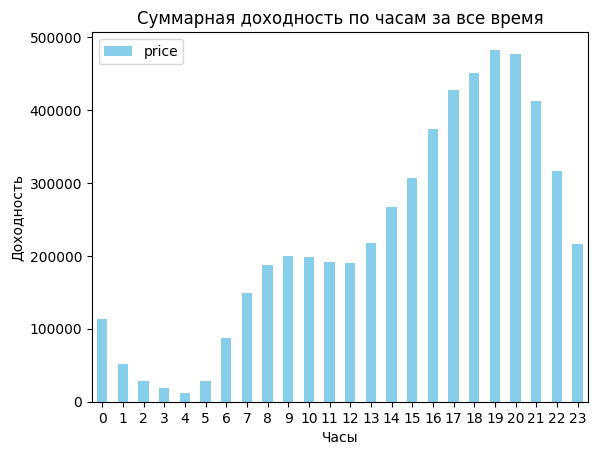

In [5]:
plt.figure(figsize=(9, 3))
sum_price_df.plot(kind='bar', color='skyblue')
plt.title('Суммарная доходность по часам за все время')
plt.xlabel('Часы')
plt.ylabel('Доходность')
plt.xticks(rotation=0)
plt.show()

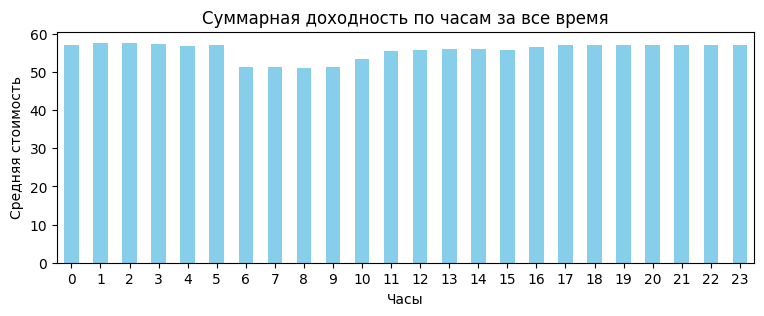

In [6]:
plt.figure(figsize=(9, 3))
mean_price_df.plot(kind='bar', color='skyblue')
plt.title('Суммарная доходность по часам за все время')
plt.xlabel('Часы')
plt.ylabel('Средняя стоимость')
plt.xticks(rotation=0)
plt.show()


#### Вывод

На основе графического анализа можно сделать следующие выводы:
* Самый большие доходы компания получает с 16:00 и до 21:00. Вероятно, люди после окончания рабочего дня спешат домой и, чтобы быстрее добраться берут самокаты.
* Самые маленькие доходы компания получает с 3:00 до 4:00. Это логично, так как в это время все спят.
* Доходы с самокатов утром меньше, чем вечером. То есть люди, когда идут на работу, выбираю самокаты реже, чем после работы(Конечно, играет роль и акция, но доходы значительно ниже и это не может быть вызвано одной только акцией). 
* Средняя стоимость поездки статична в течение всего дня, но с 6 до 10 заметен значительный спад. Вероятно, это вызвано проведением акции "Быстрый старт".

### 2. Стимулирует ли акция спрос на самокаты?

#### Подготовка данных

Так как акция проводится только по понедельникам с 6 до 10. То для анализа стоит брать дни недели, который будут статистически похожи на понедельник. Ближе всего к понедельнику оказалась пятница, но для анализа мы так же дополнительно возьмем вторник, среду и четверг.

In [110]:
df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])

# Берём только поездки с 6 до 10
df = df[(df['start_date'].dt.hour >= 6) & (df['start_date'].dt.hour <= 9)]

# Добавление столбца с днем недели
df['day'] = df['start_date'].dt.day_name()

#### Корреляционный анализ

Мы проверим 2 корреляции: 

1. Зависит ли спрос по утрам от дня недели.
2. Зависит ли спрос по утрам(будем брать данные с пятницы и понедельника) от проведения акции.

Так как в исследованиях, которые проводились до этого, выяснилось, что данные по спросу(поездкам) распределены ненормально, то при расчёте корреляции мы будет использовать критерии Манна-Уитни и Краскела-Уоллеса

##### Зависит ли спрос по утрам по дня недели.

In [111]:
from scipy.stats import kruskal

# Подсчет количества поездок по дням недели
rides_per_day = df['day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
grouped_data = [df[df['day'] == day]['id'].values for day in rides_per_day.index]

# Тест Манна-Уитни
stat, p_value = kruskal(*grouped_data)

print(p_value < 0.05)


True


Так как p_value < 0.05, то спрос по утрам действительно зависит от дня недели

##### Зависит ли спрос по утрам от проведения акции.

In [112]:
from scipy.stats import mannwhitneyu

# Группировка данных по наличию акции
md_fr_df = df[(df['day'] == 'Monday') | (df['day'] == 'Friday')]

promo_group = md_fr_df[md_fr_df['promo'] == 1]  
no_promo_group = md_fr_df[md_fr_df['promo'] == 0]

# Тест Манна-Уитни
stat, p_value = mannwhitneyu(promo_group['id'], no_promo_group['id'], alternative='two-sided')

print(p_value < 0.05)

True


Так как p_value < 0.05, то спрос по утрам действительно зависит от проведения акции

#### Графический анализ

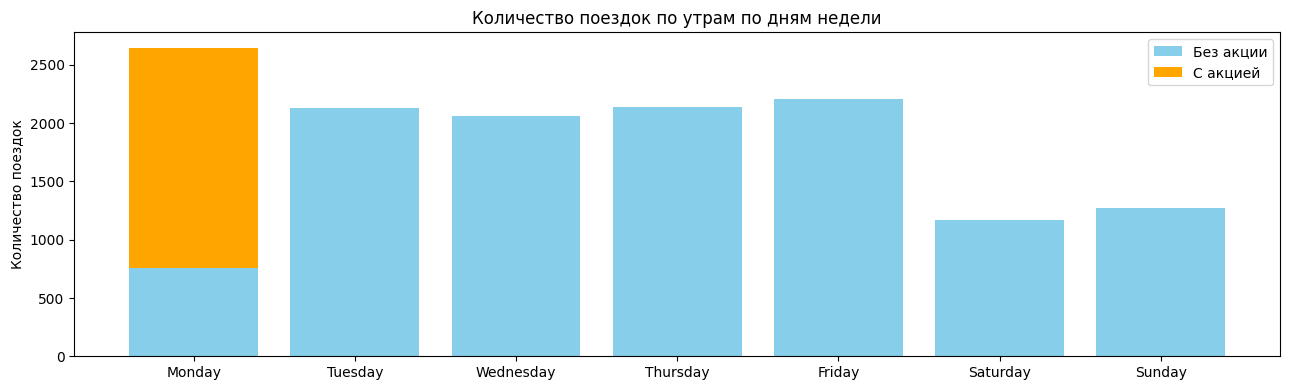

In [116]:
# Группировка данных по наличию акции и дню недели
grouped_data = df.groupby(['day', 'promo']).size().unstack(fill_value=0)

# Переупорядочивание индексов для правильного отображения
grouped_data = grouped_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Построение бар-графика
plt.figure(figsize=(13, 4))
bars = plt.bar(grouped_data.index, grouped_data[0], color='skyblue', label='Без акции')  # Поездки без акции
bars2 = plt.bar(grouped_data.index, grouped_data[1], bottom=grouped_data[0], color='orange', label='С акцией')  # Поездки с акцией
plt.title('Количество поездок по утрам по дням недели')
plt.xlabel('')
plt.ylabel('Количество поездок')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Графически видно, что в понедельник спрос действительно гораздо больше и около 75% людей воспользовались акцией

#### Вывод

На основании проведенного исследования можно сказать, что: 
* Акция действительно стимулирует спрос
* Самый высокий спрос в день проведения акции(понедельник), а самвй низкий по выходным
* Спрос на самокаты утром действительно зависит от дня недели

### 3. Исследование корреляцию между параметрами погодных условий

#### Первичный анализ

Перед началом исследования стоит понять как распределены данные, чтобы выбрать правильный коэффицент. Будем использовать тест Шапиро-Уилка и графический анализ.

temperature  -  0.0
precipitation_total  -  0.0
wind_gust  -  0.0
wind_speed  -  0.0
cloud_cover_total  -  0.0
sunshine_duration  -  0.0


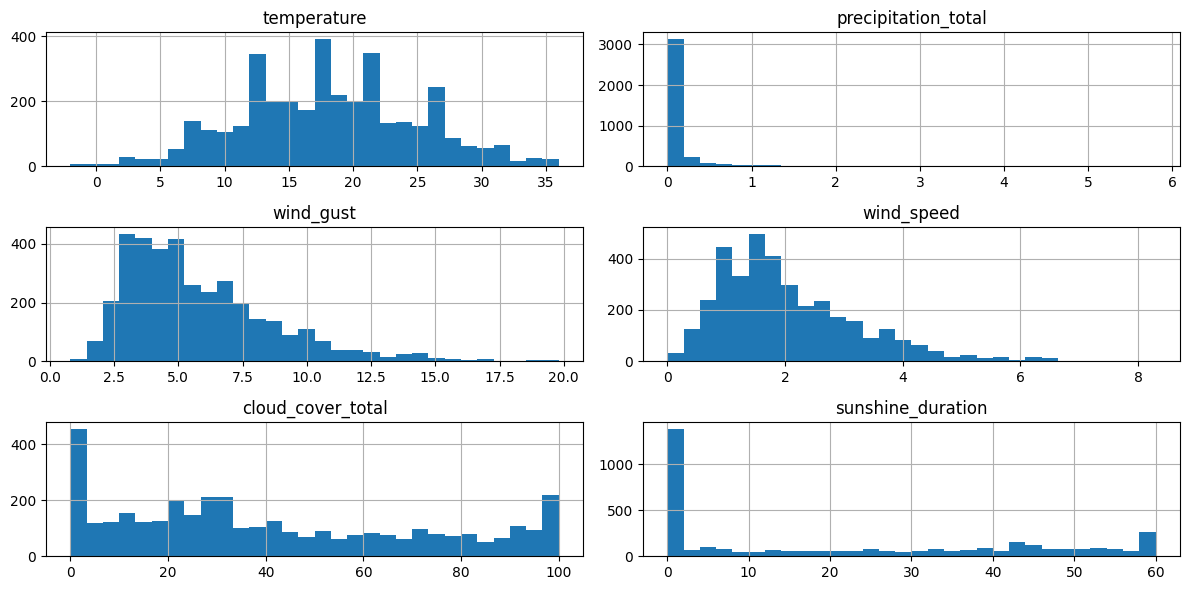

In [49]:
from scipy.stats import shapiro

df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Приведение колонок к float, кроме колонки с датами
for col in df.columns[1:]:
    df[col] = df[col].astype(float)

# Проверяем данные через тест Шапиро-Уилка
for col in df.columns[1:]:
    stat, p_value = shapiro(df[col])  
    print(col, ' - ', p_value.round(5))

# Строим график
df.drop('datetime', axis=1).hist(bins=30, figsize=(12, 6))
plt.tight_layout()
plt.show()

По данным из теста Шапиро-Уилка и из графиков можно сделать вывод, что все данные распределены ненормально, следовательно, так как все данные количественные, то будет использовать коэффицент Спирмена для поиска корреляций. 

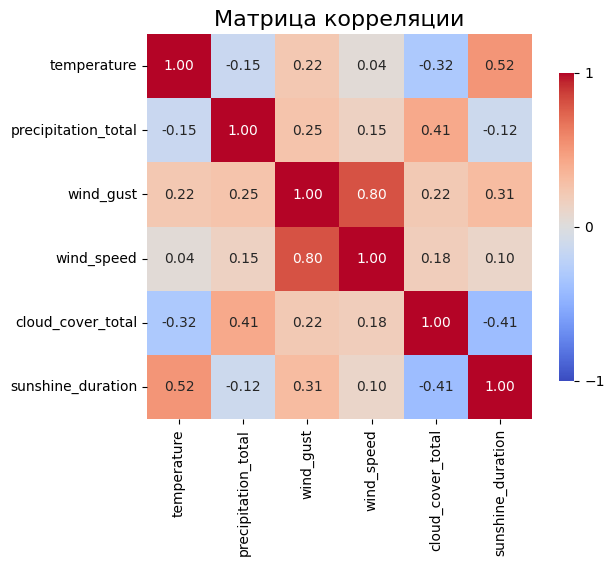

In [17]:
# Так как в исследледовании мы исследуем только параметры погодных условий, то удаляем datetime
df = df.drop('datetime', axis=1)

# Строим матрицу корреляций
corr_df = df.corr(method='spearman')

# Настройка графика
plt.figure(figsize=(7, 5))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8, "ticks": [-1, 0, 1]}, vmin=-1, vmax=1)
plt.title('Матрица корреляции', fontsize=16)
plt.show()

Исследуем данные, где корреляционное значение больше 0.3 или меньше < -0.3, то есть данные, как минимум с умеренной корреляцией.

Нам подходят следующие корреляции:

* Умеренные
    1. Облачность и температура (Обратная зависимость)
    2. Облачность и общее количество осадков
    3. Порывы ветра и продолжительность солнечного сияния 
    4. Продолжительность солнечного сияния и облачность (Обратная зависимость)
* Заметная
    1. Продолжительность солнечного сияния и температура
* Высокая
    1. Скорость ветра и порывы ветра

#### Умеренные

##### 1. Облачность и температура

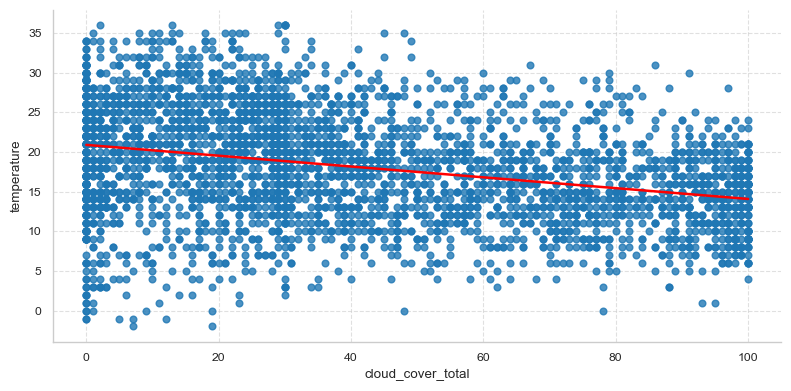

In [131]:
sns.set_context("paper")
sns.lmplot(x="cloud_cover_total", y="temperature", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается слабая умеренная обратная корреляция между факторами. Её легко объяснить. Когда на небе много облаков, то лучи солнца хуже доходят до земли и нагревают её, следовательно температура падает.

То есть можно сделать вывод, что облачность выступает как ограничивающий фактор для связи между продолжительностью солнечного сияния и температурой, смягчая их влияние. При высокой облачности воздействие солнечного сияния на температуру становится менее выраженным, но корреляция между солнечным сиянием и температурой остается значимой.

##### 2. Облачность и общее количество осадков

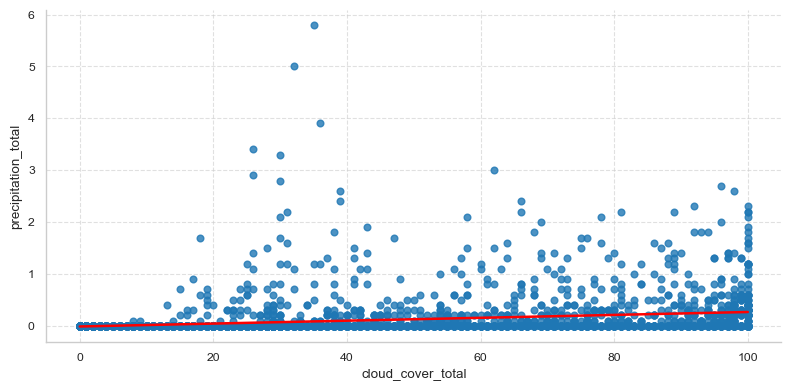

In [134]:
sns.set_context("paper")
sns.lmplot(x="cloud_cover_total", y="precipitation_total", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается умеренная корреляция между факторами. Её легко объяснить. Когда на небе много облаков, то, вероятно и погода хуже, а следовательно вероятность дождя выше.

То есть можно сделать вывод, что облачность выступает как основной фактор, влияющий на количество осадков.

##### 3. Порывы ветра и продолжительность солнечного сияния 

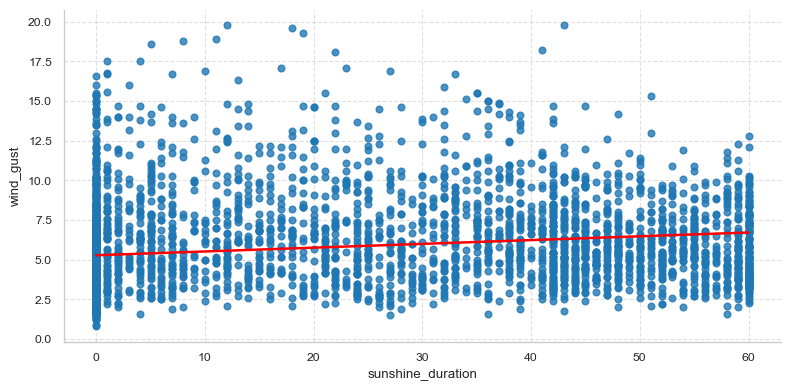

In [144]:
sns.set_context("paper")
sns.lmplot(x="sunshine_duration", y="wind_gust", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается слабая умеренная корреляция между факторами. Её так легко объяснить. Вероятно, при появлении воздушных масс, блокирующих солнечные лучи, порывы ветра их сгоняют.

То есть можно сделать вывод, что связь между этими факторами является особенностью представленных данных и выступает как бы случайным "шумом".

##### 4. Продолжительность солнечного сияния и облачность 

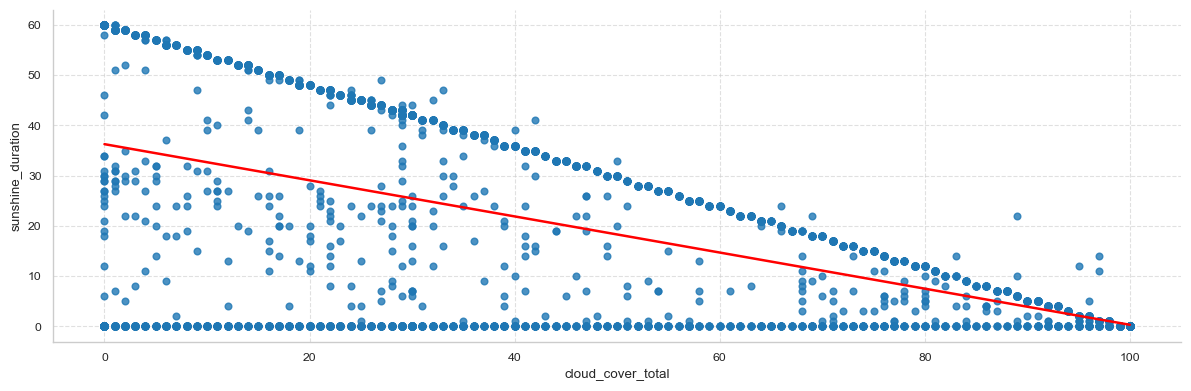

In [143]:
sns.set_context("paper")
sns.lmplot(x="cloud_cover_total", y="sunshine_duration", data=df, ci=None, aspect=3, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается умеренная обратная корреляция между факторами. Её легко можно объяснить. Когда на небе много облаков, то лучи солнца хуже доходят до земли.

То есть можно сделать вывод, что облачность выступает как основной фактор от которого зависит продолжительность солнечного сияния. Данный вывод подкрепляет вывод из первого пункта(1. Облачность и температрура).

#### Заметные

##### 1. Продолжительность солнечного сияния и температура

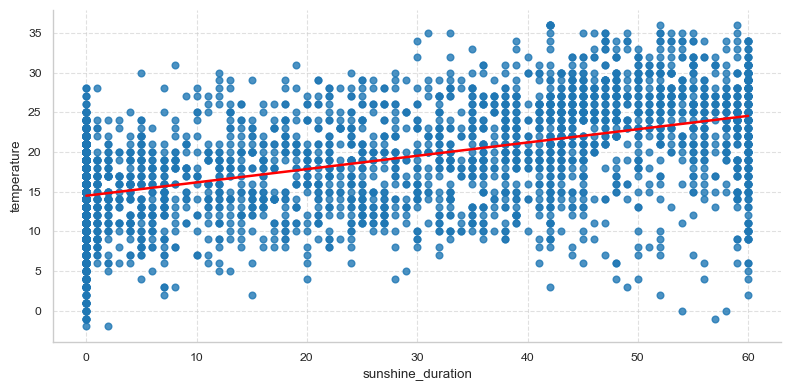

In [149]:
sns.set_context("paper")
sns.lmplot(x="sunshine_duration", y="temperature", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается заметная корреляция между факторами. Её легко можно объяснить. Чем дольше солнце светит и ему ничего не мешает, то тем сильнее нагревается Земля и растет температура.

То есть можно сделать вывод, что продолжительность солнечного сияния выступает как основной фактор от которого зависит температура.

#### Высокие

##### 1. Скорость ветра и порывы ветра

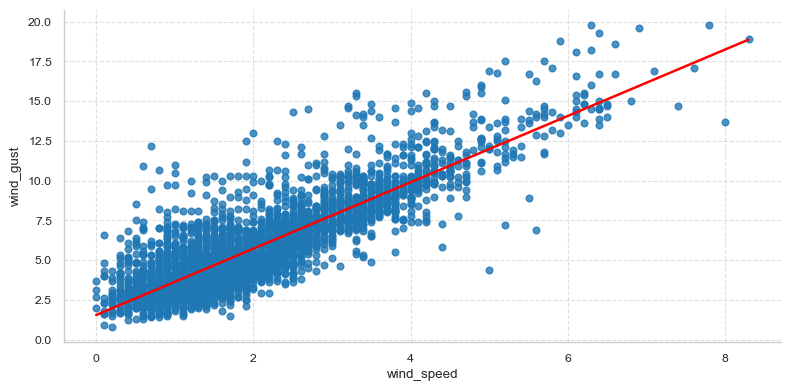

In [ ]:
sns.set_context("paper")
sns.lmplot(x="wind_speed", y="wind_gust", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается высокая корреляция между факторами. Её легко можно объяснить. Чем выше скорость ветка, тем соответственно и ветреннее погода, следовательно и больше скорость порывов ветра.

То есть можно сделать вывод, что скорость ветра выступает как основной фактор от которого зависит скорость порывов ветра.

#### Вывод

На основе проведенного исследования можно сделать следующие выводы:

- Температура в первую очередь зависит от продолжительность солнечного сияния. Но так же от облачности, которая выступает как ограничивающий фактор для связи между.
- Общее количество осадков зависит больше всего от облачности.
- Скорость порывов ветра почти полностью зависят от скорости ветра.

### 4. Подготовка таблицы с почасовым трафиком в каждой точке. 


#### Создание таблицы

In [182]:
df = pd.read_csv('processed_rides.csv', parse_dates=['end_date', 'start_date'])

traffic_data = {}

# Уникальные локации
locations = pd.concat([df['start_location'], df['end_location']]).unique()

for location in locations:
    # Аггрегируем приезды и отьезды по часам
    arrivals = df[df['end_location'] == location].resample('h', on='end_date').size()
    departures = df[df['start_location'] == location].resample('h', on='start_date').size()

    # Добавление в словарь
    traffic_data[location + '_П'] = arrivals # Приезд
    traffic_data[location + '_О'] = departures # Отъезд

    # traffic_data[location + '_В'] = arrivals.add(departures, fill_value=0) # Приезд + Отъезд = Всего

# Новый DataFrame
traffic_by_hours = pd.DataFrame(traffic_data).fillna(0).astype(int)

# Месяц временной метки
traffic_by_hours['month'] = traffic_by_hours.index.month_name(locale='ru')

traffic_by_hours.head(3)

шевченко_П  шевченко_О  чехова_П  чехова_О  буденного_П  \
2023-04-22 09:00:00           0           1         0         2            0   
2023-04-22 10:00:00           1           0         0         0            0   
2023-04-22 11:00:00           0           0         0         0            0   

                     буденного_О  труда_П  труда_О  первомайская_П  \
2023-04-22 09:00:00            2        0        1               0   
2023-04-22 10:00:00            2        0        1               1   
2023-04-22 11:00:00            1        0        0               0   

                     первомайская_О  ...  чапаева_О  степная_П  степная_О  \
2023-04-22 09:00:00               1  ...          0          0          0   
2023-04-22 10:00:00               0  ...          0          1          0   
2023-04-22 11:00:00               1  ...          0          1          0   

                     трудовая_П  трудовая_О  железнодорожная_П  \
2023-04-22 09:00:00           0           0                  0   
2023-04-22 10:00:00           1           0                  0   
2023-04-22 11:00:00           2           0                  1   

                     железнодорожная_О  мира_П  мира_О   month  
2023-04-22 09:00:00                  0       0       0  Апрель  
2023-04-22 10:00:00                  0       0       0  Апрель  
2023-04-22 11:00:00                  0       0       0  Апрель  

[3 rows x 183 columns]

#### Выгрузка таблицы

In [183]:
# Убираем индексацию с datetime
traffic_by_hours = traffic_by_hours.reset_index()
traffic_by_hours.rename(columns={'index': 'datetime'}, inplace=True)

# Сохраняем таблицу
traffic_by_hours.to_csv('traffic_by_hours.csv', index=False)

### 5. Определение топ-3 точки с самым высоким трафиком. 

1. Есть ли точки, которые можно закрыть? 
2. Какие самые популярные направления перемещения? 
3. Есть ли необходимость в конце дня перераспределять самокаты по точкам?

In [118]:
df = pd.read_csv('processed_rides.csv', parse_dates=['end_date', 'start_date'])
traffic_by_hours = pd.read_csv('traffic_by_hours.csv', parse_dates=['datetime'])

##### Топ-3 точки по общему трафику

In [119]:
top = ((df['start_location'].value_counts() + df['end_location'].value_counts()).to_frame()).sort_values('count', ascending=False)

top.head(3)

count
луговая      4530
ломоносова   4499
спортивная   4461

##### Топ-3 начальных и конечных точек по трафику 

Начальные

In [120]:
top_start = df['start_location'].value_counts().to_frame()
top_end = df['end_location'].value_counts().to_frame()

top_start.head(3)

count
start_location       
луговая          2276
ломоносова       2274
майская          2216

Конечные

In [121]:
top_end.head(3)

count
end_location       
спортивная     2293
восточная      2270
буденного      2267

Несмотря на то, что мы искали топ-3 улицы, было замечено, что существует резкий рост спроса и в точках старта и в точках конца между значениями в 1550 и 2150. Это позволяет нам говорить об особой категории улиц с супер-сильным трафиком. К супер-улицам будем относить улицы с суммарным трафиком за весь период более 4000. На данный момент к супер-улицам можно отнести: <b>спортивная, восточная, буденного, луговая, майская, ломоносова</b>.

##### 2.1 Есть ли точки, которые можно закрыть?

Чтобы ответить на этот вопрос провизуализируем трафик в каждой точке за все время наблюдения

In [145]:
# Из трафика по часам создаем новый датафрейм где содержится информация о приездах и отьездах из локации за все время
traffic = traffic_by_hours.melt(var_name='location_type', value_name='count')
traffic[['location', 'type']] = traffic['location_type'].str.split('_', expand=True)
traffic = traffic.drop('location_type', axis=1)

traffic['type'] = traffic['type'].map({'О': "Отъезд", "П": "Приезд"})
traffic = traffic.groupby(['location', 'type'], as_index=False)['count'].sum()

traffic.head(4)

location    type count
0  береговая  Отъезд   865
1  береговая  Приезд   826
2  березовая  Отъезд  1224
3  березовая  Приезд  1212

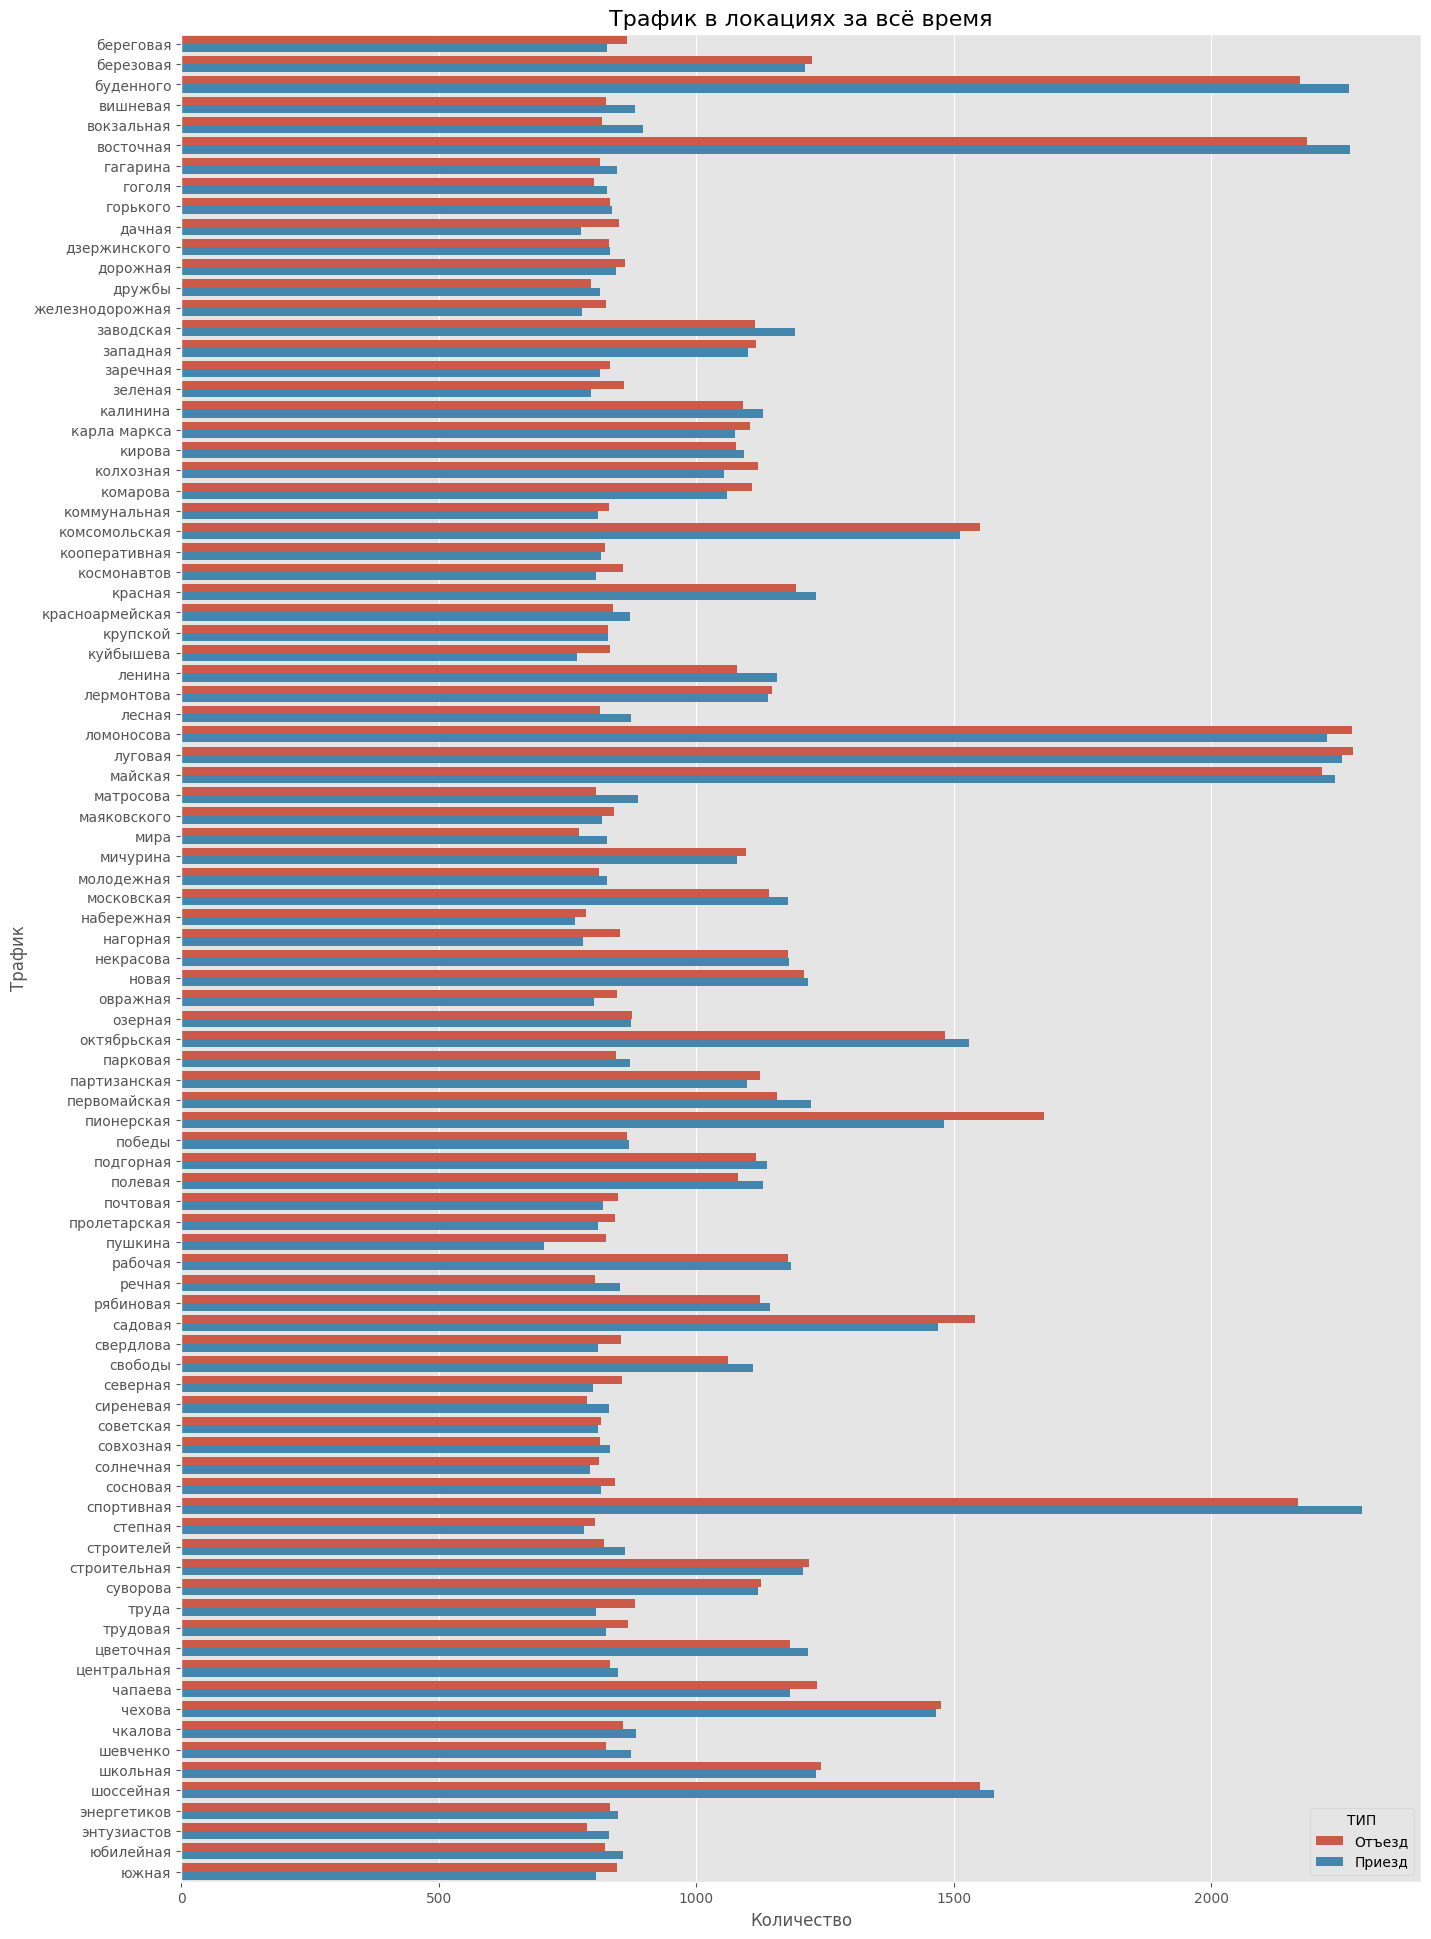

In [123]:
# Провизуализируем данные
plt.figure(figsize=(16, 24))
sns.barplot(traffic, y='location', x='count', hue='type')

plt.title('Трафик в локациях за всё время', fontsize=16)
plt.legend(title='ТИП')

plt.xlabel('Количество')
plt.ylabel('Трафик')

plt.show()

По представленной информации сложно сказать стоит ли закрывать какие-либо точки, посмотрим на трафик в точках по месяцам

In [124]:
# Сначала отфильтруем данные, исключив апрель, так как мы имеем не полные данные за апрель
filtered_traffic = traffic_by_hours[traffic_by_hours['month'] != 'Апрель']

# Не берем данные за август, они не значительны
traffic_by_months = filtered_traffic.groupby('month').sum(numeric_only=True).iloc[1:] 

traffic_by_months = traffic_by_months.sort_index()

months_order = ['Май', 'Июнь', 'Июль']

# Преобразование индексов для правильной сортировки месяцов
traffic_by_months.index = pd.Categorical(traffic_by_months.index, categories=months_order, ordered=True)

traffic_by_months = traffic_by_months.sort_index()
traffic_by_months.min(axis=1)

Май     193
Июнь    216
Июль    239
dtype: int64

Минимальный из минимальных трафиков замечен в мае, что логично, ведь сезон самокатов только начинается, после своего начала в конце апреля

In [125]:
# Работа с начальным DataFrame
df['month'] = df['start_date'].dt.month_name(locale='ru')

# Считаем общий трафик по каждой точке в апреле и выводим в порядке возрастания
((df[df['month'] == 'Май']['start_location'].value_counts() + df[df['month'] == 'Май']['end_location'].value_counts()).sort_values()).head(10)

набережная       410
пушкина          415
гоголя           418
степная          420
мира             421
дружбы           439
кооперативная    443
пролетарская     444
сиреневая        444
речная           446
Name: count, dtype: int64

Исходя из данных, можно закрыть точки с наименьшим трафиком в мае, но так же стоит учитывать общий трафик за всё время. В общем и целом, почти все точки показывают равномерный трафик. Главные кандидаты на закрытие - это точки с низким трафиком и большой разницей между приездающими и уезжающими. Ярким примером такой улицы является улица Пушкина. Но так же стоит отталкиваться от их географическое положение, чтобы трафик перераспредилился равномерно

##### 2.2 Какие самые популярные направления перемещения?

In [214]:
# Считаем количество каждого маршрута за все время наблюдения
routes = df.groupby(['start_location', 'end_location']).size().reset_index(name='count')
routes.sort_values(by='count', ascending=False).head(10) # Выводим самые популярные маршруты

start_location end_location  count
184       буденного    буденного     68
3256        луговая   спортивная     67
6586     спортивная      майская     59
3347        майская   спортивная     59
489       восточная   ломоносова     58
3277        майская    буденного     58
3165     ломоносова   спортивная     58
490       восточная      луговая     58
6555     спортивная    восточная     58
3219        луговая      луговая     55

##### Посмотрим на популярные маршруты в разные месяца

In [215]:
months_names = {4: 'апрель', 5: 'май', 6: 'июнь', 7: 'июль'}

# Новая колонка - месяц
df['month'] = df['start_date'].dt.month.map(months_names) 

# Группируем маршруты по месяцам
month_routes = df.groupby(['month', 'start_location', 'end_location']).size().reset_index(name='count')

# Таблица с топ 3 маршрутами по месяцам
month_routes.groupby('month').apply(lambda x: x.nlargest(3, 'count'), include_groups=False)

start_location end_location  count
month                                          
апрель 1853         луговая   спортивная      9
       1763      ломоносова  октябрьская      8
       2420           новая      луговая      8
июль   11033     спортивная      майская     27
       7863         луговая   спортивная     25
       7734      ломоносова   ломоносова     24
июнь   12820      буденного    буденного     31
       15628     ломоносова   спортивная     24
       18843     спортивная    восточная     24
май    20922      восточная   ломоносова     22
       23437        луговая      луговая     22
       22462  комсомольская    буденного     20

Неудивительно, что в топе по каждому месяцу находятся маршруты, где есть супер-улицы.

##### 2.3 Есть ли необходимость в конце дня перераспределять самокаты по точкам?

In [ ]:
# Группируем по локации и считаем
grouped = traffic.groupby(['location', 'type']).sum().reset_index()

# Переводим данные в формат, удобный для вычислений
pivot = grouped.pivot(index='location', columns='type', values='count').fillna(0)

# Вычисляем остаток самокатов
pivot['Остаток'] = pivot.get('Приезд', 0) - pivot.get('Отъезд', 0)

# Выводим 10 самых больших и 10 маленьких улиц по остатку
top_10 = pivot.nlargest(10, 'Остаток')
bottom_10 = pivot.nsmallest(10, 'Остаток')

print("10 улиц по переизбытку:")
print(top_10[['Остаток']])

print("\n10 улиц по нехватке:")
print(bottom_10[['Остаток']])

10 улиц по переизбытку:
type          Остаток
location             
спортивная        125
буденного          94
восточная          84
матросова          82
вокзальная         79
заводская          78
ленина             78
первомайская       66
лесная             60
вишневая           57

10 улиц по нехватке:
type        Остаток
location           
пионерская     -194
пушкина        -120
труда           -76
дачная          -73
нагорная        -73
садовая         -71
колхозная       -67
куйбышева       -64
зеленая         -63
северная        -57


На основе анализа общего трафика можно сделать вывод, что в долгосрочный перспективе самокаты будут скапливаться или полностью пропадать из точке. Поэтому <u>необходимо</u> перераспределять их по точкам.

##### Вывод

На основании проведённого исследования можно сделать следующие выводы:
* Можно закрывать точки с низким трафиком и большой разницей между приездающими и уезжающими
* Существует особая категория супер-улиц с самым большим трафиком. На данный момент к супер-улицам можно отнести: <b>спортивная, восточная, буденного, луговая, майская, ломоносова</b>
* Почти все самые популярные маршруты направлены либо из, либо в супер-улицу
* Самокаты <u>необходимо</u> перераспределять в конце дня по точкам. Точки нужно мониторить.

### 6. Изучить накопительное поведение разницы в трафике в каждой точке.

Определить необходимое количество самокатов в каждой точке и в каждом районе
для удовлетворения спроса в полном объеме. <br>
(Предполагаем, что ежедневно в 6:00 самокаты перераспределяются к исходной позиции)

#### Подготовка данных

In [149]:
df = pd.read_csv('processed_rides.csv', parse_dates=['end_date', 'start_date'])

# Так как самокаты перераспределяются в 6 утра каждый день, нам надо скорректировать дату наблюдения за трафиком, 
# тоесть рассматриваем трафик с 6 утра до 6 утра следующего дня
def adjust_date(row):
    if row['start_date'].hour < 6:
        return row['start_date'] - pd.Timedelta(days=1)
    return row['start_date']

df['adjusted_date'] = df.apply(adjust_date, axis=1).dt.date

df.head(3)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   

  start_district end_location end_district  distance  promo adjusted_date  
0  юго-восточный      майская  октябрьский      4069      0    2023-04-22  
1       заречный   спортивная  октябрьский      4515      0    2023-04-22  
2    октябрьский     суворова    ленинский      4520      0    2023-04-22

#### Рассчёты

In [152]:
# Добавление столбцов для отслеживания уезжающих и прибывающих самокатов
traffic = pd.DataFrame()

# Увеличиваем количество самокатов, которые уезжают из стартовой локации
traffic['location'] = df['start_location']
traffic['date'] = df['adjusted_date']
traffic['count'] = 1  # Каждый уехавший самокат увеличивает счетчик на 1

# Увеличиваем количество самокатов, которые прибывают в конечную локацию
arrivals = pd.DataFrame()
arrivals['location'] = df['end_location']
arrivals['date'] = df['end_date'].dt.date
arrivals['count'] = -1  # Каждый прибывший самокат уменьшает счетчик на 1

# Объединяем данные о выездах и прибытиях
traffic = pd.concat([traffic, arrivals])

# Группируем по дате и локации и суммируем
traffic_summary = traffic.groupby(['date', 'location']).sum().reset_index()

# Рассчитываем накопительное поведение
traffic_summary['cumulative_sum'] = traffic_summary.groupby('location')['count'].cumsum()

traffic_summary.tail(3)

date     location  count  cumulative_sum
9197  2023-08-01      чкалова     -1             -26
9198  2023-08-01     шевченко     -1             -49
9199  2023-08-01  энергетиков     -1             -16

#### Анализ данных

In [ ]:
final_result = traffic_summary.groupby('location').last().reset_index()

final_result.describe()

count  cumulative_sum
count  91.000000       91.000000
mean   -0.615385        0.000000
std     4.170716       49.872727
min   -10.000000     -125.000000
25%    -3.000000      -35.000000
50%    -1.000000       -1.000000
75%     2.000000       29.500000
max     9.000000      194.000000

Судя по средним значениям можно сказать, что у нас имеются как точки, где стабильно скапливаются самокаты, так и точки, где катастрофически не хватает самокатов. Но при этом, в среднем точка выходит в 0. Найдем самые пустые и полные точки.

Топ 5 точек, по потере самокатов

In [164]:
final_result.nlargest(5, columns=['cumulative_sum'])

location        date  count  cumulative_sum
53  пионерская  2023-07-31      4             194
59     пушкина  2023-07-31      2             120
77       труда  2023-07-31      0              76
9       дачная  2023-07-31      8              73
44    нагорная  2023-07-31     -2              73

Топ 5 точек, по сохранению самокатов

In [165]:
final_result.nsmallest(5, columns=['cumulative_sum'])

location        date  count  cumulative_sum
72  спортивная  2023-07-31     -8            -125
2    буденного  2023-07-31     -5             -94
5    восточная  2023-07-31     -1             -84
37   матросова  2023-07-31      0             -82
4   вокзальная  2023-07-31      2             -79

#### Графический анализ

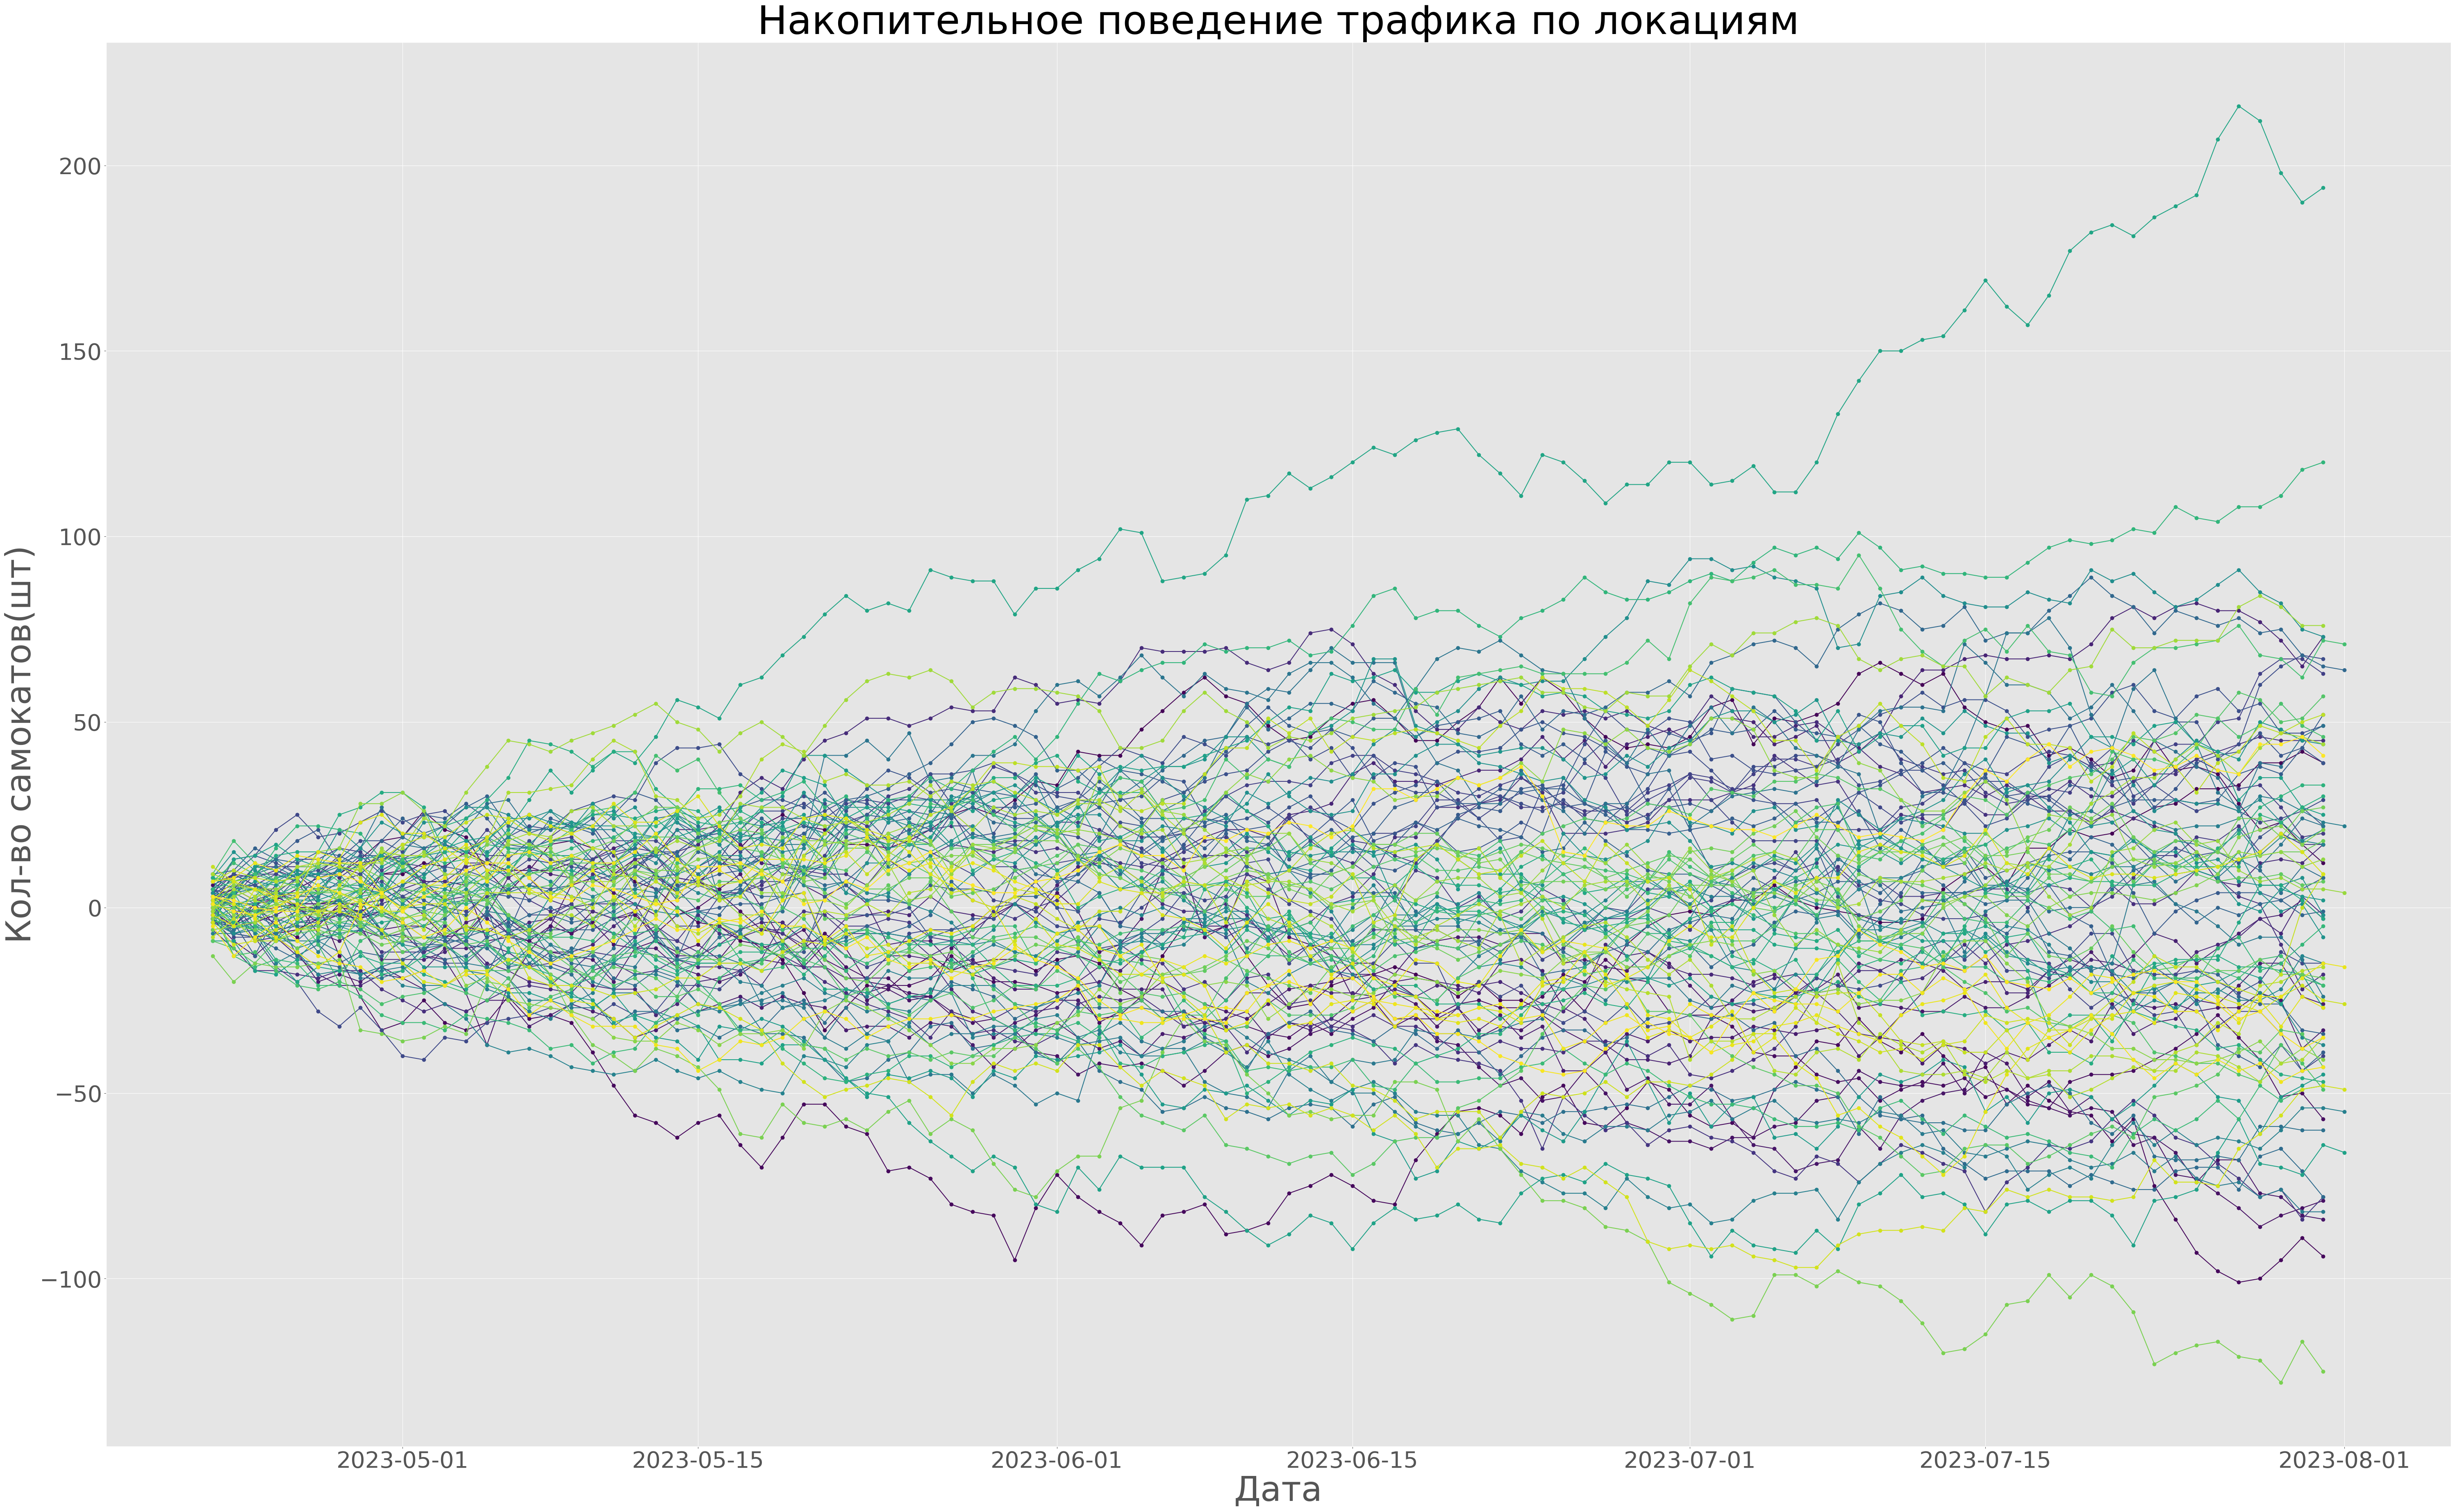

In [ ]:
# Визуализация накопительного трафика
plt.figure(figsize=(60, 37))
plt.style.use('ggplot')
colors = plt.cm.viridis(np.linspace(0, 1, len(traffic_summary['location'].unique())))

for i, location in enumerate(traffic_summary['location'].unique()):
    subset = traffic_summary[traffic_summary['location'] == location]
    plt.plot(subset['date'], subset['cumulative_sum'], marker='o', label=location, color=colors[i])

plt.title('Накопительное поведение трафика по улицам', fontsize=70)
plt.xlabel('Дата', fontsize=60)
plt.ylabel('Кол-во самокатов(шт)', fontsize=60)
plt.xticks(rotation=0, fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
# plt.legend(title='Локация', fontsize=15)
plt.tight_layout()

plt.show()

#### Вывод

На основании анализа можно сказать, что у некоторых точек количество самокатов колеблется в пределах 0 и не сильно отклоняется, их можно не трогать. Но есть группа отдельных улиц, которые стабильно теряют или переполучают самокаты. Из таких особенных улиц надо специально увозить или привозить самокаты.

### Общий вывод

1. Самый большой спрос на самокаты приходится на вечер с 16 до 21. Средняя стоимость статична.
2. Акция сильно влияет на спрос
3. Температура в первую очередь зависит от продолжительность солнечного сияния. Но так же от облачности, которая выступает как ограничивающий фактор для связи между.
4. Общее количество осадков зависит больше всего от облачности.
5. Скорость порывов ветра почти полностью зависят от скорости ветра.
6. Существуют супер-улицы с аномально большим трафиком

## Проверка гипотез

### 1. В дождливое время спрос на самокаты ниже?

H0: Спрос на самокаты <u>не зависит</u> от погодных условий

H1: Спрос на самокаты <u>зависит</u> от погодных условий

#### Подготовка данных

In [ ]:
rides_df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Устанавливаем datetime как индекс
rides_df.set_index('datetime', inplace=True)

# Ресемплируем данные по часам и считаем количество поездок
counted_rides_df = rides_df.resample('H').size().reset_index(name='rides')

# Мержим таблицу погоды и трафика по часам
rides_df = pd.merge_asof(
    weather_df, 
    counted_rides_df, 
    left_on='datetime', 
    right_on='datetime',
    direction='backward'
)

# Удаляем пропуски(например, ночь, когда самокаты не берут в аренду)
rides_df = rides_df.dropna()
rides_df = rides_df[rides_df['rides'] > 0]

# Приводим значения в таблице к числовому формату
for col in rides_df.columns[1:]:
    rides_df[col] = rides_df[col].astype(float)
    
print(f'Всего временных промежутков: {rides_df.shape[0]}')
print(f'Всего временных промежутков с дождём: {rides_df[rides_df['precipitation_total'] > 0].shape[0]}')
print(f'Всего временных промежутков с умеренным дождём и сильнее: {rides_df[rides_df['precipitation_total'] > 5].shape[0]}')

Всего временных промежутков: 3136
Всего временных промежутков с дождём: 516
Всего временных промежутков с умеренным дождём и сильнее: 1


Из открытых источников известно, что условно принято считать: 
* Cлабый дождь — 1–5 мм/ч 
* Умеренный — 5–20 мм/ч 
* Сильный — 20–40 мм/ч 
* Ливень — более 40 мм/ч 

В ходе подготовки данных о погоде выяснилось, что максимальное значение осадков не превышало 5.8 мм/ч и все дождливые дни, кроме одного, шёл слабый дождь. Поэтому в ходе анализа можно сделать только вывод на счёт слабого дождя. Имеющихся данных недостаточно, чтобы сказать о влиянии других типов дождя на спрос.

#### Расчёты

Из исследования 3(Исследование корреляцию между параметрами погодных условий) известно, что все данные о погоде распределены ненормально, следовательно при расчёте коэффицента корреляции будем использовать коэффицент корреляции Спирмена.

Сначала проверим влият ли <u>количество</u> осадков на спрос

In [179]:
from scipy.stats import spearmanr

# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['precipitation_total'], rides_df['rides'])

print(k, p_value)

0.009514361457735945 0.5943078140412971


Теперь проверим влият ли хотя бы какое-то <u>начилие</u> осадков на спрос. То есть теперь нас не волнует сколько было осадков. Нас интересует были ли они или нет.

In [180]:
# Переводим значения столбца в бинарный формат
rides_df['precipitation_total'] = rides_df['precipitation_total'].apply(lambda row: 1 if row > 0 else 0)

# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['precipitation_total'], rides_df['rides'])

print(k, p_value)

0.00853344772391502 0.6328699690146653


#### Вывод

В обоих расчётах значение коэффицента корреляции были близкими к нулю, а p-value были очень далеко от значения < 0.05. Поэтому мы отвергает H1 и принимаем H0. То есть погода не имеет никакого влияния на спрос на самокаты. Но стоит сказать, что речь одёт только о слабом дожде. То есть вывод таков: Слабый дождь не имеет никакого влияния на спрос на самокаты.

### 2. Отличается ли средняя стоимость поездки по районам?

H0: Средняя стоимость <u>не зависит</u> от района

H1: Средняя стоимость <u>зависит</u> от района

#### Подготовка данных

При расчёте итоговой стоимости будем считать, что 1 минута поездки стоит 1 рубль

In [175]:
df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])

df['price'] = df.apply(lambda row: 30 + ((row.end_date - row.start_date).seconds / 60) 
                       if row.promo == 0 
                       else ((row.end_date - row.start_date).seconds / 60),
                       axis=1)

#### Расчёты

Сначала через тест Шапиро-Уилка проверим данные на нормальность

In [176]:
from scipy.stats import shapiro

_, p_value = shapiro(df['price'])
print(p_value.round(11))

0.0


Так как p-value < 0.05, то данные распределны ненормально и при расчёте корреляции мы будем использовать критерий Краскера-Уолса, так как групп у нас гораздо больше двух. Проверим зависит ли стоимость от района.

In [179]:
from scipy.stats import kruskal

# Группируем по начальной и конечной локации
start_location_groups = df.groupby('start_location')['price'].apply(list)
end_location_groups = df.groupby('end_location')['price'].apply(list)

# Применяем критерий Краскера-Уолса
_, p_value_start = kruskal(*start_location_groups)
_, p_value_end = kruskal(*end_location_groups)

# Интерпретация результата
print(p_value_start < 0.05, p_value_end < 0.05)

True True


Дополнительно проведём графический анализ

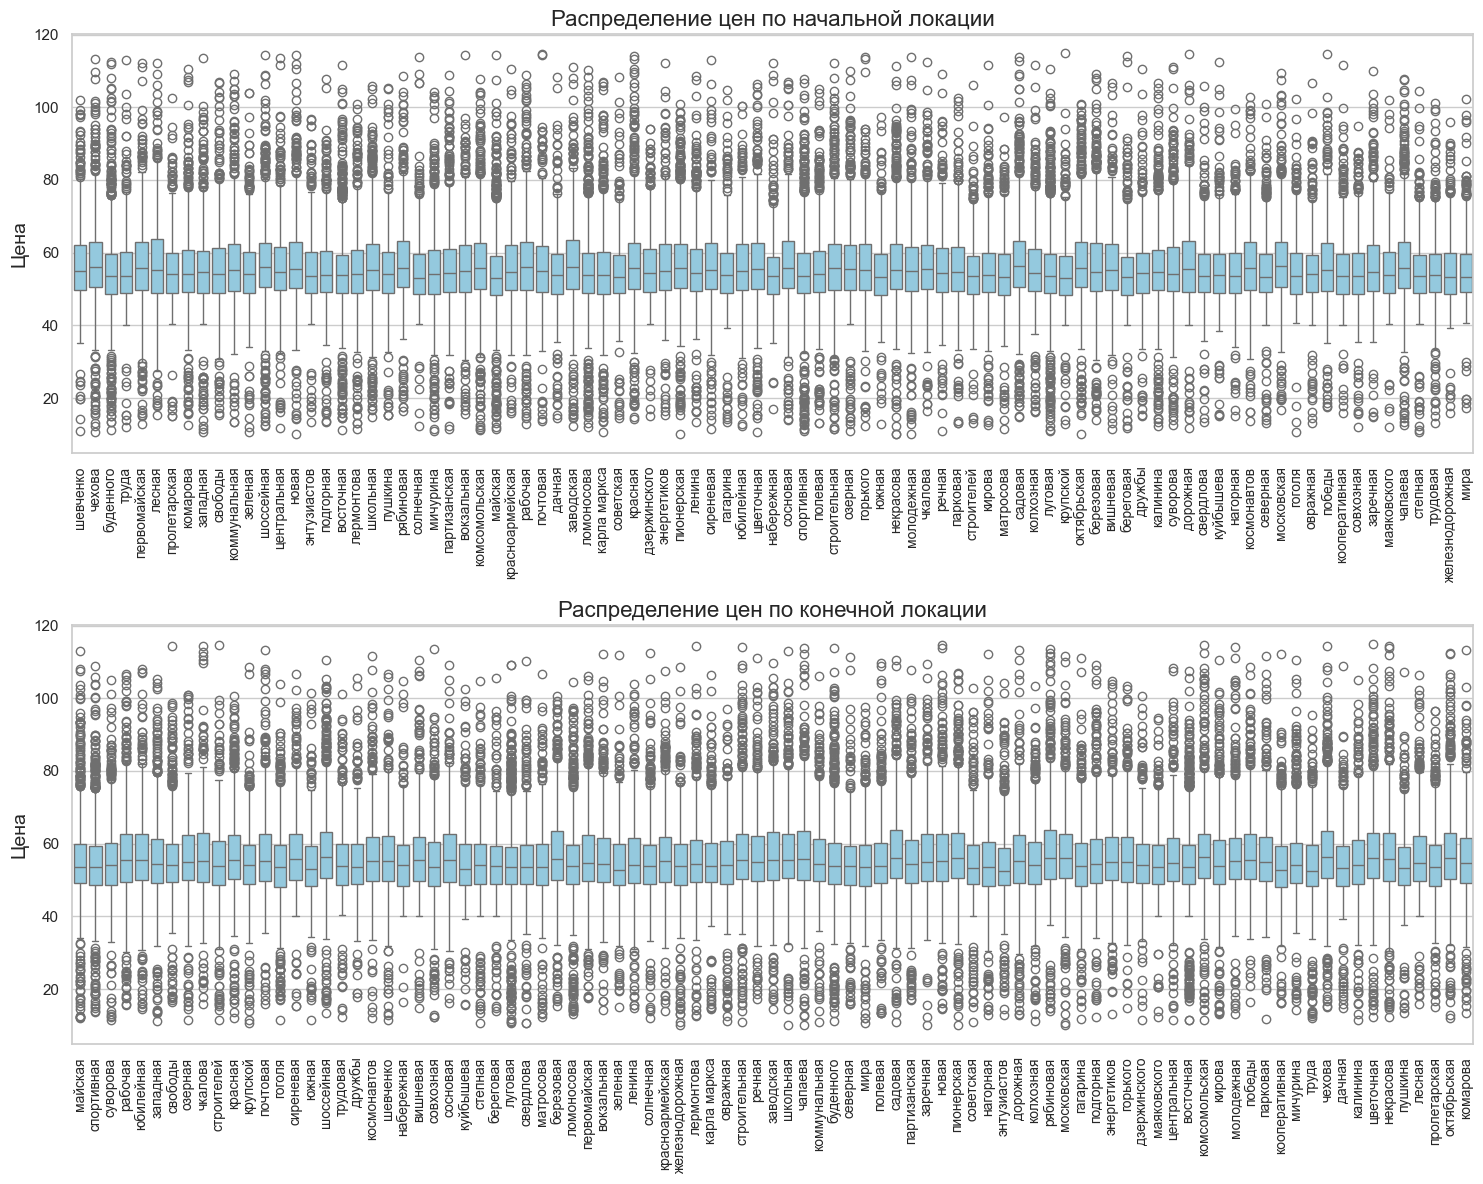

In [430]:
# Создание графиков
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Boxplot для начальной локации
sns.boxplot(x='start_location', y='price', data=df, ax=axes[0], color='skyblue')
axes[0].set_title('Распределение цен по начальной локации', fontsize=16)
axes[0].set_xlabel('')
axes[0].set_ylabel('Цена', fontsize=14)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, fontsize=10)

# Boxplot для конечной локации
sns.boxplot(x='end_location', y='price', data=df, ax=axes[1], color='skyblue')
axes[1].set_title('Распределение цен по конечной локации', fontsize=16)
axes[1].set_xlabel('')
axes[1].set_ylabel('Цена', fontsize=14)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, fontsize=10)

# Отображение графиков
plt.tight_layout()
plt.show()

Оба значения p-value оказались меньше 0.05. Но по графическому анализу особо нечего сказать. Можно сделать вывод, что средняя стоимость поезки зависит от района, где была начала и закончена поездка, то есть H0 отвергается и принимается альтернативная гипотеза.

#### Вывод

Средняя стоимость <u>зависит</u> от района. Также такой вывод подкрепляет теорию о существовании супер-улиц.

### 3. Спрос на самокаты меняется в зависимости от дня недели?

H0: Спрос на самокаты <u>не зависит</u> от дня недели

H1: Спрос на самокаты <u>зависит</u> от дня условий

#### Подготовка данных

In [14]:
df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])

# Добавление столбца с днем недели
df['day'] = df['start_date'].dt.day_name()

# Подсчет количества поездок по дням недели
rides_per_day = df['day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Группировка данных по дням недели и получение самих значений
grouped_data = [df[df['day'] == day]['id'].values for day in rides_per_day.index]

#### Расчёты

Сначала проведём графический анализ

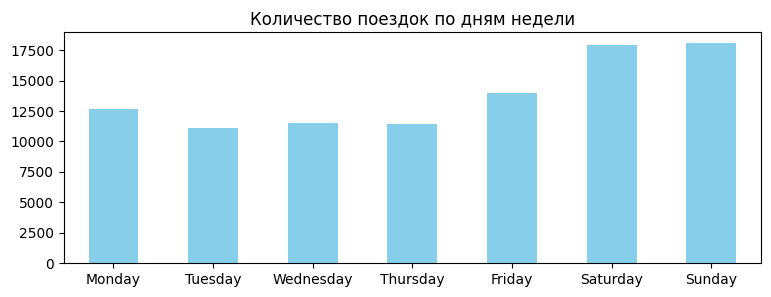

In [20]:
# Визуализация
plt.figure(figsize=(9, 3))
rides_per_day.plot(kind='bar', color='skyblue')
plt.title('Количество поездок по дням недели')
plt.xlabel('')
plt.xticks(rotation=0)
plt.show()


Проверим данные на нормальность

In [21]:
from scipy.stats import shapiro

results = {day: shapiro(data) for day, data in zip(rides_per_day.index, grouped_data)}

# Вывод результатов теста на нормальность
for day, (stat, p) in results.items():
    print(f"{day}, {p < 0.05}")

Monday, True
Tuesday, True
Wednesday, True
Thursday, True
Friday, True
Saturday, True
Sunday, True


Можно сделать вывод, что все данные распределны ненормально, следовательно мы будем использовать критерий Краскера-Уолса

In [22]:
from scipy.stats import kruskal

# Проведение теста Краскала-Уоллиса
_, p_value = kruskal(*grouped_data)

print(p_value.round(20))

0.0


Судя по p-value, существует сильная зависимость между днём недели и спросом на самокаты. 

#### Вывод

Исходя из графического и анатитического анализа, получается, что зависимость существует и мы отвергает H0. То есть спрос на самокаты <u>зависит</u> от дня условий. Также стоит сказать, что самый сильный спрос по выходным, а самый низкий с понедельника по среду.

### 4. В выходные дни поездки более длинные

H0: Длительность поездки <u>не зависит</u> от того, выходной или будний день

H1: Длительность поездки <u>зависит</u> от того, выходной или будний день

#### Подготовка данных

In [50]:
df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])

# Рассчитываем длительность поездки в минутах
df['time_delta'] = df['end_date'] - df['start_date']
df['time_delta'] = df['time_delta'].apply(lambda time: time.seconds / 60)

# Задаем порядок дней недели
df['day'] = df['start_date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day'] = pd.Categorical(df['day'], categories=days_order, ordered=True)

#### Проверка корреляции

Сначала проверим с помощью теста Шапиро-Уилка, как распределены данные о длительности поездки

In [51]:
from scipy.stats import shapiro

_, p_value = shapiro(df['time_delta'])

print(p_value < 0.05)

True


Так как p-value < 0.05, то данные распределены ненормально и при расчёте корреляции мы будем использовать тест Манна-Уитни

In [52]:
from scipy.stats import mannwhitneyu

# Создаем колонку для определения выходного или буднего дня
df['is_weekend'] = df['day'].isin(['Saturday', 'Sunday'])

# Разделяем данные на две группы
weekday_durations = df[df['is_weekend'] == False]['time_delta']
weekend_durations = df[df['is_weekend'] == True]['time_delta']

# Выполняем тест Манна-Уитни
_, p_value = mannwhitneyu(weekday_durations, weekend_durations)

# Выводим результаты
print(p_value < 0.05)

True


Действительно, так как p_value < 0.05, то корреляция существует

#### Графический анализ

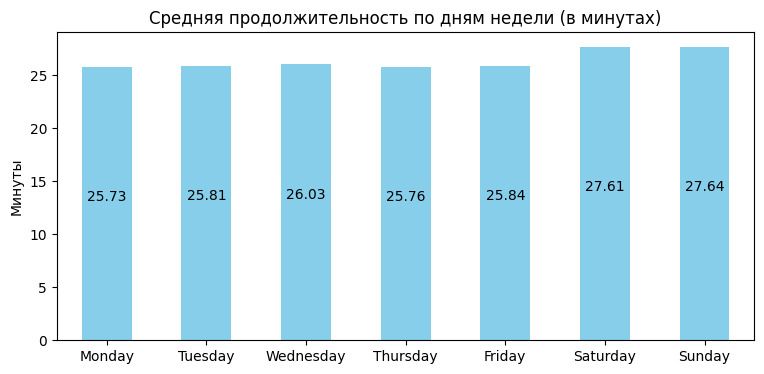

In [ ]:
# Считаем средне время поездки и переводим его в минуты
mean_price_df = df.groupby(by=['day'])['time_delta'].mean()

# Создаем график
plt.figure(figsize=(9, 4))
bars = mean_price_df.plot(kind='bar', color='skyblue')

# Подписываем бары с округлением до сотых
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() / 2, 
             f'{bar.get_height():.2f}',
             ha='center', 
             va='bottom')

plt.title('Средняя продолжительность по дням недели (в минутах)')
plt.xlabel('')
plt.ylabel('Минуты')
plt.xticks(rotation=0)
plt.show()

Графически действительно видно, что в выходные средняя длительности больше

#### Вывод

Так как значение p_value < 0.05, то мы отвергаем H0 и принимаем H1. То есть длительность поездки <u>зависит</u> от того, выходной или будний день. Но также стоит сказать, что на основании графического анализа можно сделать вывод, что хоть сильная зависимость и есть, но она средне сильно влият на среднюю длительность поездки. Разница между значениями в будние и выходные составляет примерно 7% (2 минуты).

### 5. В будние дни поездки более скоростные

H0: Средняя скорость во время поездки <u>не зависит</u> от того, выходной или будний день

H1: Средняя скорость во время поездки <u>зависит</u> от того, выходной или будний день

#### Подготовка данных

In [ ]:
df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])

# Создаем колонну ride_duration, которая содержит длительность поездки в минутах
df['ride_duration'] = df.apply(lambda row: (row.end_date - row.start_date).seconds / 60, axis = 1)

# Создаем колонку average_speed, которая хранит среднюю скорость на протяжении всего пути в км/ч
df['average_speed'] = df.apply(lambda row: (row.distance / 1000) / (row.ride_duration / 60), axis=1)

# Задаем порядок дней недели
df['day'] = df['start_date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day'] = pd.Categorical(df['day'], categories=days_order, ordered=True)

#### Проверка корреляции

Сначала проверим с помощью теста Шапиро-Уилка, как распределены данные о средней скорости

In [55]:
from scipy.stats import shapiro

_, p_value = shapiro(df['average_speed'])

print(p_value < 0.05)

True


Так как p-value < 0.05, то данные распределены ненормально и при расчёте корреляции мы будем использовать тест Манна-Уитни

In [73]:
from scipy.stats import mannwhitneyu

# Создаем колонку для определения выходного или буднего дня
df['is_weekend'] = df['day'].isin(['Saturday', 'Sunday'])

# Разделяем данные на две группы
weekday_durations = df[df['is_weekend'] == False]['average_speed']
weekend_durations = df[df['is_weekend'] == True]['average_speed']

# Выполняем тест Манна-Уитни
_, p_value = mannwhitneyu(weekday_durations, weekend_durations)

# Выводим результаты
print(p_value < 0.05)

True


Действительно, так как p_value < 0.05, то корреляция существует

#### Графический анализ

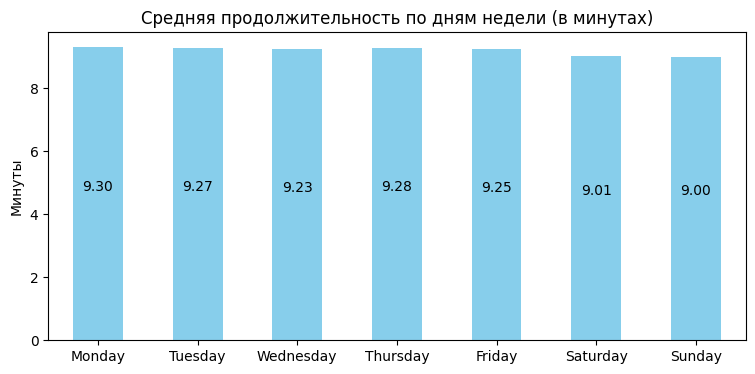

In [ ]:
# Считаем средню скорость поездки
mean_price_df = df.groupby(by=['day'])['average_speed'].mean()

# Создаем график
plt.figure(figsize=(9, 4))
bars = mean_price_df.plot(kind='bar', color='skyblue')

# Подписываем бары с округлением до сотых
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() / 2, 
             f'{bar.get_height():.2f}',
             ha='center', 
             va='bottom')

plt.title('Средняя продолжительность по дням недели (в минутах)')
plt.xlabel('')
plt.ylabel('Минуты')
plt.xticks(rotation=0)
plt.show()

#### Вывод

Так как значение p_value < 0.05, то мы отвергаем H0 и принимаем H1. То есть средняя скорость во время поездки <u>зависит</u> от того, выходной или будний день. Но также стоит сказать, что на основании графического анализа можно сделать вывод, что зависимость является обратной. То есть по выходным средняя скорость поездок наоборот меньше. Также стоит сказать, что в среднем значение скорости меняется не очень сильно, всего на 0.25 км/ч меньше по выходным.

### 6. Спрос зависит от температуры на улице

H0: Спрос на самокаты <u>не зависит</u> от температуры на улице

H1: Спрос на самокаты <u>зависит</u> от температуры на улице

#### Подготовка данных

In [167]:
rides_df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Устанавливаем datetime как индекс
rides_df.set_index('datetime', inplace=True)

# Ресемплируем данные по часам и считаем количество поездок
counted_rides_df = rides_df.resample('H').size().reset_index(name='rides')

# Мержим таблицу погоды и трафика по часам
rides_df = pd.merge_asof(
    weather_df, 
    counted_rides_df, 
    left_on='datetime', 
    right_on='datetime',
    direction='backward'
)

# Удаляем пропуски(например, ночь, когда самокаты не берут в аренду)
rides_df = rides_df.dropna()
rides_df = rides_df[rides_df['rides'] > 0]

# Приводим значения в таблице к числовому формату
for col in rides_df.columns[1:]:
    rides_df[col] = rides_df[col].astype(float)

#### Расчёты

Из исследования 3(Исследование корреляцию между параметрами погодных условий) известно, что все данные о погоде распределены ненормально, следовательно при расчёте коэффицента корреляции будем использовать коэффицент корреляции Спирмена.

In [173]:
from scipy.stats import spearmanr

# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['temperature'], rides_df['rides'])

print(k.round(3), p_value < 0.05)

0.338 True


Хоть p_value < 0.05, значение коэффицента составляет всего 0.338, что говорит о едва заметной связи между факторами.

#### Вывод

Спрос на самокаты очень слабо зависит от температуры на улице. А следовательно и солнечное сияние с облачностью не имеют даже слабого влияния на спрос(см. исследование 3).

### 7. Спрос зависит от скорости ветра на улице

H0: Спрос на самокаты <u>не зависит</u> от скорости ветра на улице

H1: Спрос на самокаты <u>зависит</u> от скорости ветра на улице

#### Подготовка данных

In [ ]:
rides_df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Устанавливаем datetime как индекс
rides_df.set_index('datetime', inplace=True)

# Ресемплируем данные по часам и считаем количество поездок
counted_rides_df = rides_df.resample('H').size().reset_index(name='rides')

# Мержим таблицу погоды и трафика по часам
rides_df = pd.merge_asof(
    weather_df, 
    counted_rides_df, 
    left_on='datetime', 
    right_on='datetime',
    direction='backward'
)

# Удаляем пропуски(например, ночь, когда самокаты не берут в аренду)
rides_df = rides_df.dropna()
rides_df = rides_df[rides_df['rides'] > 0]

# Приводим значения в таблице к числовому формату
for col in rides_df.columns[1:]:
    rides_df[col] = rides_df[col].astype(float)

#### Расчёты

Из исследования 3(Исследование корреляцию между параметрами погодных условий) известно, что все данные о погоде распределены ненормально, следовательно при расчёте коэффицента корреляции будем использовать коэффицент корреляции Спирмена.

In [174]:
from scipy.stats import spearmanr

# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['wind_speed'], rides_df['rides'])

print(k.round(3), p_value < 0.05)

0.213 True


Хоть p_value < 0.05, значение коэффицента составляет всего 0.213, что говорит о том, что между факторами нет никакой связи.

#### Вывод

Спрос на самокаты <u>не зависит</u> от скорости ветра на улице

### Общий вывод

1. Спрос не зависит от дождя
2. Средняя стоимость зависит от района
4. Спрос на самокаты зависит от дня недели и выше всего в выходные
4. В выходные дли поездки более длинные
5. В будние дни поездки быстрыее, чем в выходные
6. Спрос на самокаты не зависит от температуры на улице
7. Спрос на самокаты не зависит от скорости ветра на улице

## Регрессионное моделирование

### Подготовка данных

In [195]:
rides_df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Новый df почасовых поездок во всех точках
rides_per_hour = rides_df.groupby(rides_df['start_date'].dt.round('h')).size().reset_index(name='rides')

rides_per_hour.rename(columns={'start_date': 'datetime'}, inplace=True)

# Обьединеям данные о почасовых поездках и погоде
df = pd.merge_asof(
    rides_per_hour, 
    weather_df, 
    on='datetime',
    direction='backward'
)

### Создание новых признаков и определение факторов

После проведения исследований и проверки гипотез мы выделели основные факторы, которые влияют на спрос на самокаты. К ним относятся:
* Время (в часах)
* День недели
* Выходной ли день
* Вечер ли
* Утро ли
* Проведена ли акция

Все остальные факторы не имеют такого сильного влияния и мы их не используем

In [196]:
df = df.drop(columns=['wind_gust', 'wind_speed', 'cloud_cover_total', 'sunshine_duration', 'precipitation_total', 'temperature'])

# Добавляем новые факторы
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_of_week + 1

df['is_promo_time'] = df['day_of_week'] == 1 & df['hour'].between(6, 9)
df['is_weekend'] = df['day_of_week'] >= 6
df['is_evening'] = df['hour'].between(16, 21)
df['is_morning'] = df['hour'].between(6, 10)

# Факторы для модели
factors = ['hour', 'day_of_week', 'is_promo_time', 'is_weekend', 'is_evening', 'is_morning']

### Тренировка модели

In [228]:
X = df.drop(columns=['datetime', 'rides'])
y = df['rides']

# Разделяем данные для анализа
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Шаг 2: Обучение модели линейной регрессии
model = LinearRegression()

# Обучение на всех тренировочных данных
model.fit(X_train, y_train)
print('')

### Проверка работы

In [230]:
# Прогнозирование
y_pred = model.predict(X_test).round().astype(int)

# Обработка отрицательных значений (если такие появляются)
y_pred = np.maximum(y_pred, 0)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод интерпретации результатов
print(f"=== Результаты оценки модели ===")
print(f"MSE (Mean Squared Error): {mse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"R² (R-squared): {r2:.2f}")

=== Результаты оценки модели ===
MSE (Mean Squared Error): 224.46
MAE (Mean Absolute Error): 11.49
R² (R-squared): 0.75


### Визуализация результата работы модели

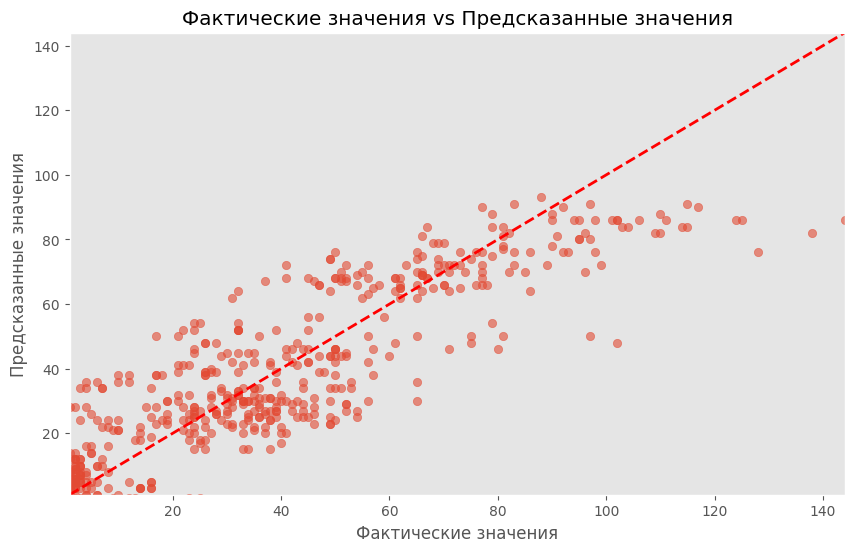

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns

# График рассеяния: фактические значения против предсказанных
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Линия y=x
plt.title('Фактические значения vs Предсказанные значения')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()
